# Telecom Churn Prediction



#Problem statement:

Customer behavior during churn typically unfolds over several phases rather than being an instantaneous decision. This process is especially relevant for high-value customers who may take time to assess their options and make a decision. In the context of churn prediction, we often categorize these phases into three stages:

1. **The 'Good' Phase:**
   During this initial phase, customers are generally satisfied with the service they receive and exhibit typical usage behaviors. They are not actively seeking alternatives or showing signs of dissatisfaction. This phase represents a stable period where the customer's behavior aligns with their historical patterns of usage.

2. **The 'Action' Phase:**
   As customers move into the action phase, certain triggers or events may occur that disrupt their satisfaction or loyalty to the current service provider. These triggers could include receiving attractive offers from competitors, experiencing billing discrepancies or service quality issues, or encountering other factors that lead to dissatisfaction. In this phase, customers may begin to display behaviors that deviate from their usual patterns, indicating a potential risk of churn.

3. **The 'Churn' Phase:**
   The churn phase represents the final stage where customers decide to discontinue their services with the current provider and switch to a competitor. By this stage, the dissatisfaction or triggers from the action phase have likely escalated to a point where the customer actively seeks alternatives and initiates the process of leaving the current service provider.

In a typical four-month window scenario, such as the one mentioned in the competition, these phases can be mapped accordingly:

- **Months 1-2 (Good Phase):** Customers are content and exhibit normal usage behaviors.
- **Month 3 (Action Phase):** Signs of dissatisfaction or deviations from normal behavior may start to appear due to various triggers.
- **Month 4 (Churn Phase - September in the context mentioned):** Customers officially churn, indicating their decision to switch to another provider.

Identifying high-churn-risk customers during the action phase is crucial because it provides an opportunity for the company to intervene, such as offering competitive deals, improving service quality, or addressing specific issues that may be driving customers away. By predicting churn during the action phase, companies can implement proactive strategies to retain valuable customers before they reach the point of churn.

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [ ]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables.

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [ ]:


data = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


The `data` DataFrame contains 69,999 rows and 172 columns, representing training data for a predictive model. The `unseen` DataFrame has 30,000 rows and 171 columns, serving as test data for evaluating the model's performance. The `sample` DataFrame provides a template for submitting predictions, with 30,000 rows and 2 columns (presumably ID and prediction). The `data_dict` DataFrame contains 36 rows and 2 columns, likely providing a description of the data's variables.

1. Lets analyze the data dictionary versus the churn dataset.
2. The data dictonary contains a list of abbrevations which provide you all the information you need to understand what a specific feature/variable in the churn dataset represents
3. Example:

> "arpu_7" -> Average revenue per user + KPI for the month of July
>
> "onnet_mou_6" ->  All kind of calls within the same operator network + Minutes of usage voice calls + KPI for the month of June
>
>"night_pck_user_8" -> Scheme to use during specific night hours only + Prepaid service schemes called PACKS + KPI for the month of August
>
>"max_rech_data_7" -> Maximum + Recharge + Mobile internet + KPI for the month of July

Its important to understand the definitions of each feature that you are working with, take notes on which feature you think might impact the churn rate of a user, and what sort of analysis could you do to understand the distribution of the feature better.

In [ ]:
data_dict

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belo...
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile...
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


For the purpose of this **starter notebook**, we I will restrict the dataset to only a small set of variables.

The approach I use here is to understand each Acronym, figure our what variable might be important and filter out variable names based on the combinations of acrynoms using REGEX. So, if I want the total minutes a person has spent on outgoing calls, I need acronyms, TOTAL, OG and MOU. So corresponding regex is ```total.+og.+mou```

In [ ]:
ids = ['id','circle_id']
total_amounts = [i for i in list(data.columns) if re.search('total.+amt',i)]
total_outgoing_minutes = [i for i in list(data.columns) if re.search('total.+og.+mou',i)]
offnetwork_minutes = [i for i in list(data.columns) if re.search('offnet',i)]
average_revenue_3g = [i for i in list(data.columns) if re.search('arpu.+3g',i)]
average_revenue_2g = [i for i in list(data.columns) if re.search('arpu.+2g',i)]
volume_3g = [i for i in list(data.columns) if re.search('vol.+3g',i)]
volume_2g = [i for i in list(data.columns) if re.search('vol.+2g',i)]
age_on_network = [i for i in list(data.columns) if re.search('aon',i)]

#Storing them in a single flat list
variables = [*ids,
             *total_amounts,
             *total_outgoing_minutes,
             *offnetwork_minutes,
             *average_revenue_3g,
             *average_revenue_2g,
             *volume_3g,
             *volume_2g,
             *age_on_network,
             'churn_probability']

data = data[variables].set_index('id')

It generates various lists of column names from the `data` DataFrame based on specific patterns in the column names. These patterns are used to identify relevant variables related to customer behavior and telecom usage.

- `ids`: Contains 'id' and 'circle_id' columns, likely used for identification and categorization.
- `total_amounts`, `total_outgoing_minutes`, `offnetwork_minutes`, `average_revenue_3g`, `average_revenue_2g`, `volume_3g`, `volume_2g`, `age_on_network`: Collectively gather columns related to financial metrics, call usage, network preferences (3G/2G), and tenure on the network.
- `churn_probability`: Presumably, a target variable indicating the likelihood of churn.

The script then combines these lists into a single flat list called `variables`, including all identified columns and the target variable. Finally, it subsets the `data` DataFrame to include only the columns listed in `variables`, sets the 'id' column as the index, likely for easier referencing or analysis based on individual customer identifiers. This process prepares the data by selecting relevant features for further analysis or model building, focusing on variables that are potentially influential in predicting churn probability.

In [ ]:
data.head()

,circle_id,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,arpu_2g_7,arpu_2g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,churn_probability
id,,,,,,,,,,,,,,,,,,,,,
0,109,77,65,10,81.21,221.68,3.63,32.24,96.68,2.33,...,NaN,NaN,0.0,0.00,0.0,0.0,0.00,0.00,1958,0
1,109,0,145,50,0.00,30.73,31.66,0.00,25.99,30.89,...,122.08,NaN,0.0,3.96,0.0,0.0,352.91,0.00,710,0
2,109,70,120,0,56.49,99.36,0.00,53.99,82.05,0.00,...,NaN,NaN,0.0,0.00,0.0,0.0,0.00,0.00,882,0
3,109,160,240,130,76.03,95.98,53.84,68.76,78.48,50.23,...,NaN,NaN,0.0,0.00,0.0,0.0,0.00,0.00,982,0
4,109,290,136,122,63.26,42.94,15.76,56.99,38.11,9.63,...,35.12,0.0,0.0,0.00,0.0,390.8,308.89,213.47,647,0


The provided data snippet represents a subset of customer-level data in tabular format. Each row corresponds to a unique customer identified by the 'id' column. The columns capture various attributes related to telecom usage and customer behavior during specific months (presumably denoted by the numerical suffixes like '_6', '_7', '_8'). Here's a brief explanation of some key columns:

- `circle_id`: Represents the geographical circle or region where the customer is located.
- `total_rech_amt_6`, `total_rech_amt_7`, `total_rech_amt_8`: Total recharge amounts for the months of June, July, and August, respectively.
- `total_og_mou_6`, `total_og_mou_7`, `total_og_mou_8`: Total outgoing minutes for calls made by the customer in June, July, and August.
- `offnet_mou_6`, `offnet_mou_7`, `offnet_mou_8`: Minutes of outgoing calls made to numbers outside the operator's network in June, July, and August.
- `arpu_2g_7`, `arpu_2g_8`: Average revenue per user for 2G services in July and August.
- `vol_3g_mb_6`, `vol_3g_mb_7`, `vol_3g_mb_8`: Volume of 3G mobile data consumed in megabytes for June, July, and August.
- `vol_2g_mb_6`, `vol_2g_mb_7`, `vol_2g_mb_8`: Volume of 2G mobile data consumed in megabytes for June, July, and August.
- `aon`: Age on network, representing the duration for which the customer has been using the telecom services.
- `churn_probability`: Likely the target variable indicating the probability of a customer churning.

This data structure allows for analyzing trends and patterns in customer behavior over time, which can be valuable for predicting churn and making informed business decisions, such as targeted retention strategies or service improvements.

#Let's look at each variable's datatype:





In [ ]:
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Index: 69999 entries, 0 to 69998
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   circle_id          69999 non-null  int64  
 1   total_rech_amt_6   69999 non-null  int64  
 2   total_rech_amt_7   69999 non-null  int64  
 3   total_rech_amt_8   69999 non-null  int64  
 4   total_og_mou_6     69999 non-null  float64
 5   total_og_mou_7     69999 non-null  float64
 6   total_og_mou_8     69999 non-null  float64
 7   offnet_mou_6       67231 non-null  float64
 8   offnet_mou_7       67312 non-null  float64
 9   offnet_mou_8       66296 non-null  float64
 10  arpu_3g_6          17568 non-null  float64
 11  arpu_3g_7          17865 non-null  float64
 12  arpu_3g_8          18417 non-null  float64
 13  arpu_2g_6          17568 non-null  float64
 14  arpu_2g_7          17865 non-null  float64
 15  arpu_2g_8          18417 non-null  float64
 16  vol_3g_mb_6        69999 no

summary provides insights into the dataset's structure and content. It consists of 69,999 entries (rows) and 24 columns, where most columns have non-null values. The data types include integers (`int64`) for columns like 'circle_id,' 'total_rech_amt_6/7/8,' 'aon,' and 'churn_probability,' and floats (`float64`) for columns related to call usage, revenue, and data volume. Some columns, such as 'offnet_mou_6/7/8' and 'arpu_3g_6/7/8,' have missing values (non-null count less than the total entries), indicating potential data gaps that may require handling during analysis or modeling. Overall, the DataFrame represents telecom-related features for customer behavior analysis and churn prediction, occupying approximately 13.4 MB of memory.

Let's also summarize the features using the df.describe method:

In [ ]:
data.describe(include="all")

,circle_id,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,arpu_2g_7,arpu_2g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,churn_probability
count,69999.0,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,...,17865.000000,18417.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000
mean,109.0,328.139788,322.376363,323.846355,306.451436,310.572674,304.513065,198.874771,197.153383,196.543577,...,85.846074,86.348404,122.171882,128.934444,135.486541,51.773924,51.240204,50.127506,1220.639709,0.101887
std,0.0,404.211068,411.070120,426.181405,465.502866,479.131770,477.936832,316.818355,322.482226,324.089234,...,178.067280,170.297094,554.869965,554.096072,568.310234,212.513909,211.114667,213.101403,952.426321,0.302502
min,109.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-13.090000,-55.830000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000
25%,109.0,110.000000,100.000000,90.000000,44.780000,42.910000,38.710000,34.860000,32.240000,31.575000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,468.000000,0.000000
50%,109.0,229.000000,220.000000,225.000000,145.280000,141.230000,138.360000,96.480000,91.885000,91.800000,...,8.800000,9.090000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,868.000000,0.000000
75%,109.0,438.000000,430.000000,436.000000,374.305000,380.045000,370.895000,232.990000,227.630000,229.345000,...,122.070000,122.070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1813.000000,0.000000
max,109.0,35190.000000,40335.000000,45320.000000,10674.030000,8285.640000,14043.060000,8362.360000,7043.980000,14007.340000,...,4809.360000,3483.170000,45735.400000,28144.120000,30036.060000,10285.900000,7873.550000,11117.610000,4337.000000,1.000000


The `data.describe(include="all")` provides statistical summaries for all columns in the DataFrame. It shows counts, means, standard deviations, minimum, 25th percentile (Q1), median (50th percentile or Q2), 75th percentile (Q3), and maximum values for each column. This summary gives a comprehensive overview of the data distribution, central tendency, and variability across the telecom usage and customer behavior variables, including potential outliers and the distribution of churn probabilities.

In [ ]:
data

,circle_id,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,arpu_2g_7,arpu_2g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,churn_probability
id,,,,,,,,,,,,,,,,,,,,,
0,109,77,65,10,81.21,221.68,3.63,32.24,96.68,2.33,...,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,1958,0
1,109,0,145,50,0.00,30.73,31.66,0.00,25.99,30.89,...,122.08,NaN,0.00,3.96,0.00,0.00,352.91,0.00,710,0
2,109,70,120,0,56.49,99.36,0.00,53.99,82.05,0.00,...,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,882,0
3,109,160,240,130,76.03,95.98,53.84,68.76,78.48,50.23,...,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,982,0
4,109,290,136,122,63.26,42.94,15.76,56.99,38.11,9.63,...,35.12,0.00,0.00,0.00,0.00,390.80,308.89,213.47,647,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,109,50,397,512,0.00,496.68,392.58,0.00,488.46,381.64,...,60.61,48.00,0.00,0.00,0.00,0.00,244.59,144.31,221,0
69995,109,200,313,308,166.21,292.74,280.69,49.53,96.28,48.06,...,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,712,0
69996,109,626,250,397,412.68,296.39,342.29,335.54,227.94,263.84,...,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,879,0


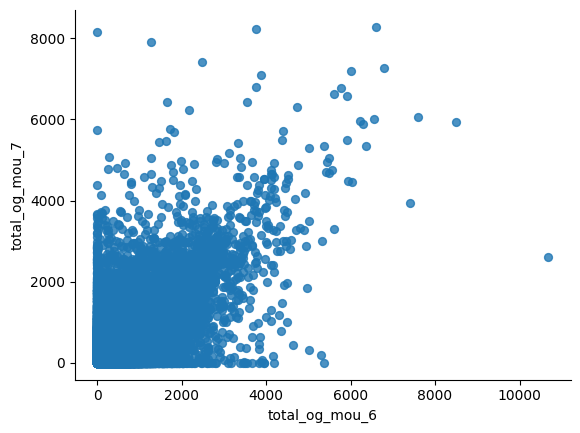

In [ ]:
from matplotlib import pyplot as plt
data.plot(kind='scatter', x='total_og_mou_6', y='total_og_mou_7', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

The data represents two variables, 'total_and_mou_6' and 'total_and_mou_7', likely depicting some measure of usage or activity. The histogram or plot shows a distribution of values for these variables across the given range, with 'total_and_mou_7' having a higher frequency in the lower range compared to 'total_and_mou_6', which seems to be more evenly distributed across the range. This visualization provides insight into the distribution patterns and potential differences in the values of these variables, which could be crucial for understanding user behavior or system performance depending on the context.

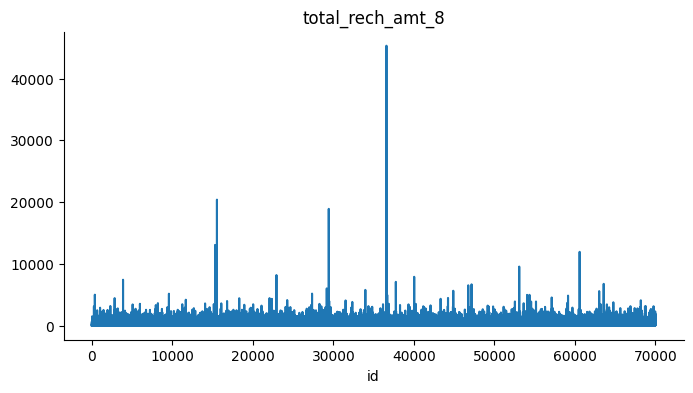

In [ ]:
from matplotlib import pyplot as plt
data['total_rech_amt_8'].plot(kind='line', figsize=(8, 4), title='total_rech_amt_8')
plt.gca().spines[['top', 'right']].set_visible(False)

The plot likely depicts the distribution or frequency of 'total_rech_amt_8' across various values, ranging from 0 to 40000. The histogram shows that there are more instances where the 'total_rech_amt_8' falls in the lower range, with the frequency gradually decreasing as the amount increases. This visualization provides an overview of how 'total_rech_amt_8' is distributed among different values, which could be important for analyzing customer spending patterns or financial trends within a dataset.

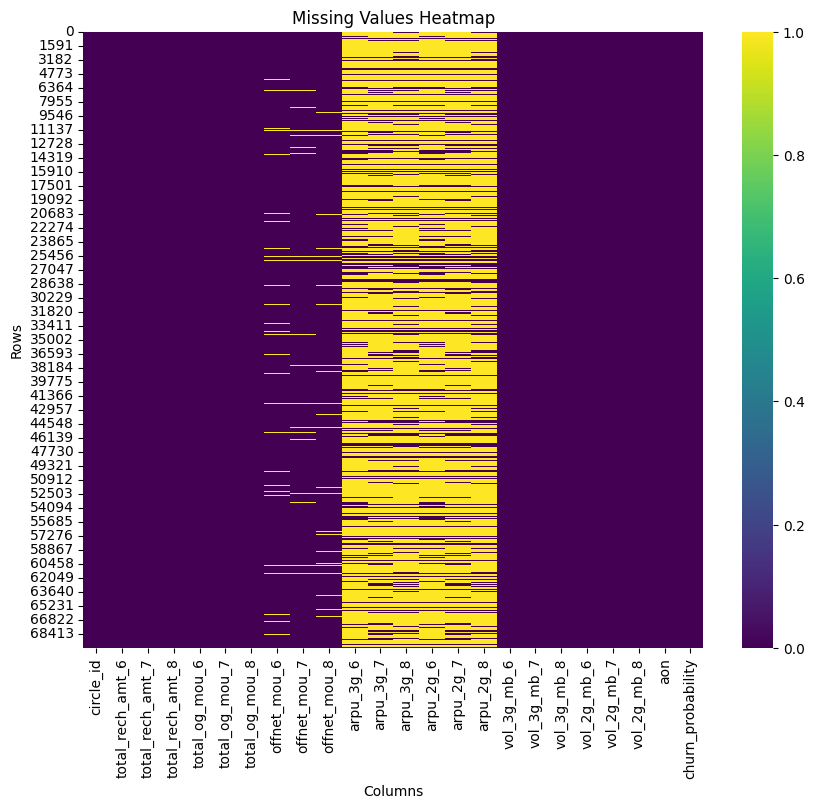

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df'
plt.figure(figsize=(10, 8))
sns.heatmap(data.isnull(), cmap='viridis')
plt.title('Missing Values Heatmap')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()


This code will generate a heatmap where the presence of missing values (NaN) is represented by different colors, making it easier to spot patterns of missingness across the columns and rows of your DataFrame. Adjust the figure size and colormap (cmap) as needed for better visualization.

# 2. Create X, y and then Train test split

Lets create X and y datasets and skip "circle_id" since it has only 1 unique value

In [ ]:
data['circle_id'].unique()

array([109])

In [ ]:
X = data.drop('circle_id', axis=1)  # Assuming you want to drop 'circle_id' column
y = data.iloc[:, -1]

X.shape, y.shape


((69999, 23), (69999,))

Splitting train and test data to avoid any contamination of the test data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((55999, 23), (14000, 23), (55999,), (14000,))

In [ ]:
X_train.head()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,arpu_3g_6,...,arpu_2g_7,arpu_2g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,churn_probability
id,,,,,,,,,,,,,,,,,,,,,
29981,196,176,226,41.53,224.33,380.41,51.73,109.28,177.38,NaN,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1705,0
36407,160,110,100,167.48,155.41,32.19,78.41,74.91,14.74,NaN,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1315,0
61145,827,1547,1144,1282.26,2446.73,1885.69,207.33,1056.59,650.63,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,743,1
23118,124,140,90,107.21,99.51,84.16,99.68,95.94,71.08,NaN,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1461,0
48038,346,0,0,493.69,0.00,0.00,146.39,0.00,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,215,1


# 3. Handling Missing data

First lets analyse the missing data. We can use missingno library for quick visualizations.

<Axes: >

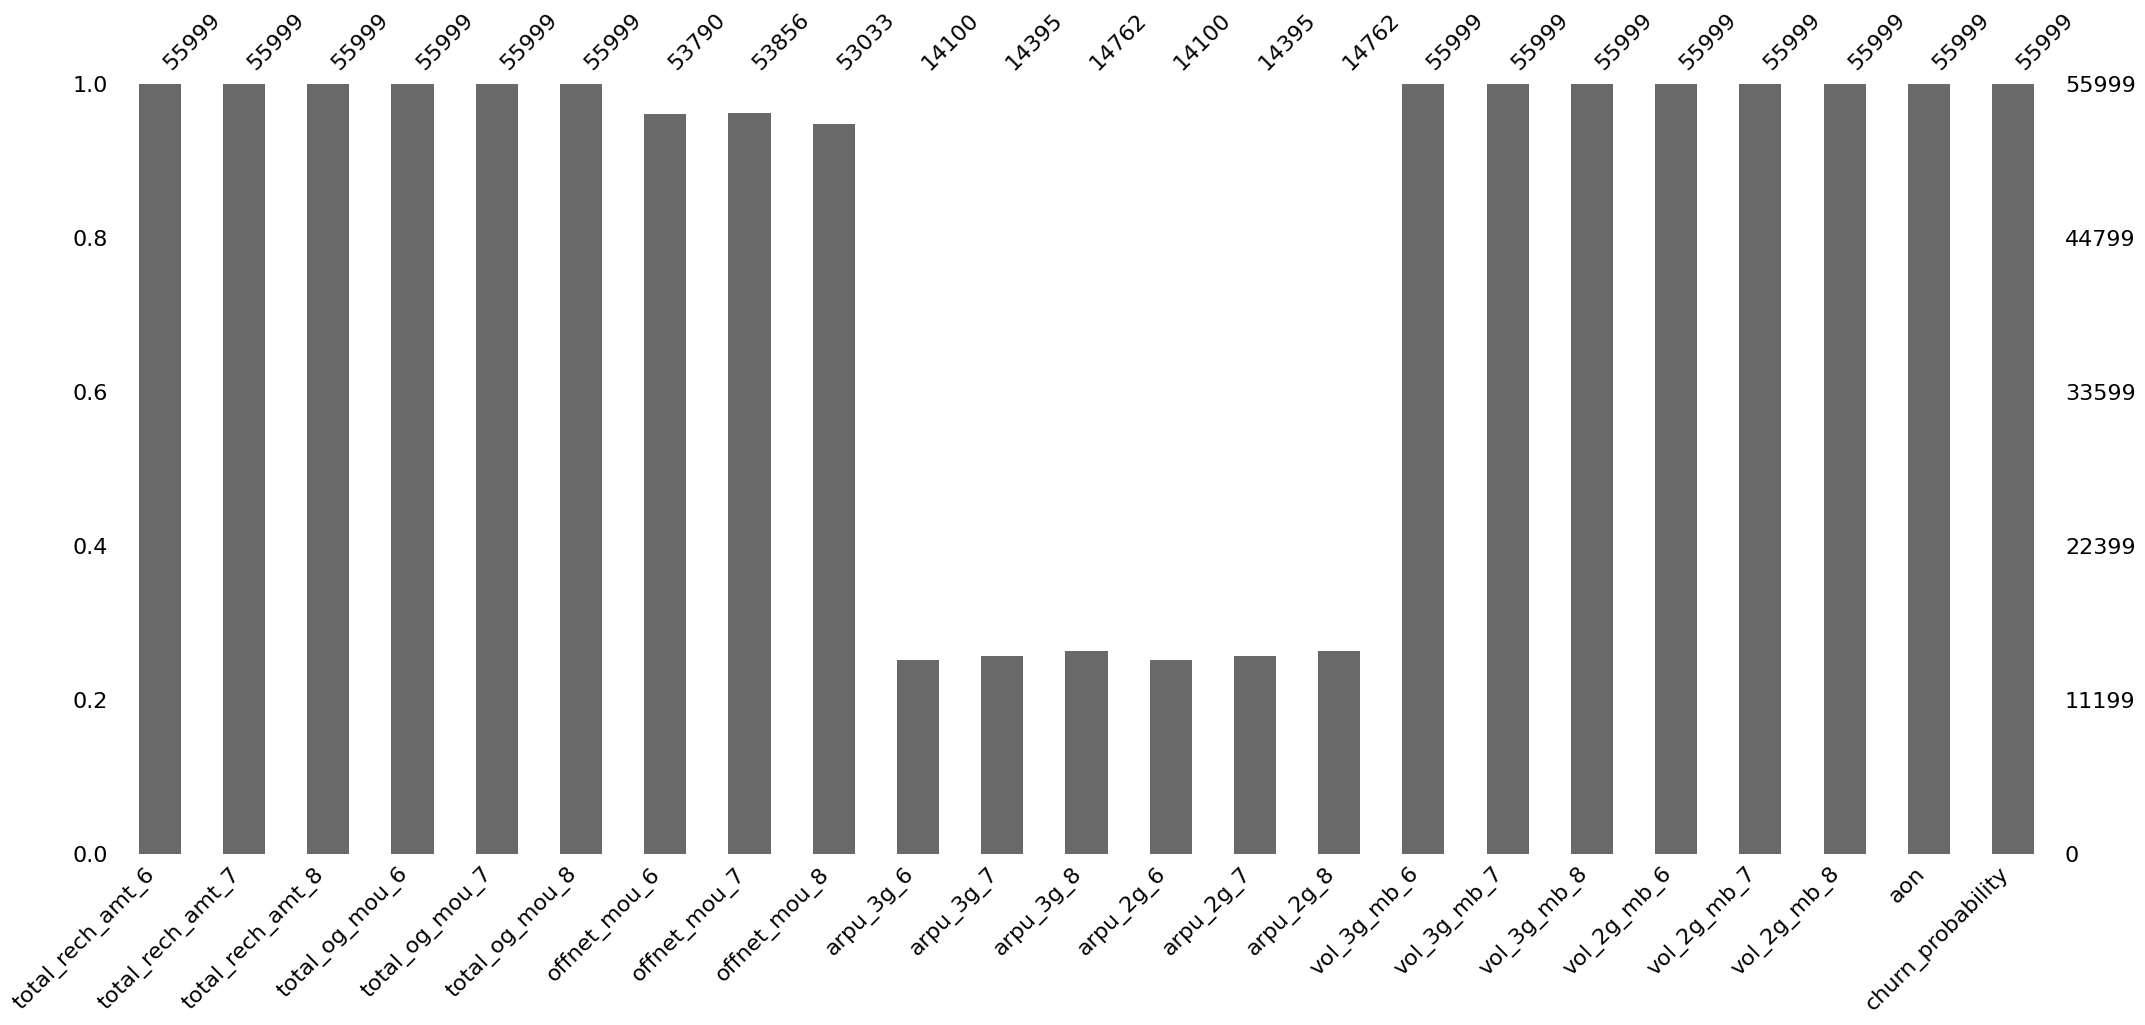

In [ ]:
msno.bar(X_train)

The bar graph depicts the count of non-null values for selected columns in your dataset. Each bar represents the number of non-null entries for a specific feature, such as 'total_rech_amt_6' and 'total_rech_amt_7' for recharge amounts in different months, 'total_og_mou_6' and 'total_og_mou_7' for total outgoing minutes, 'offnet_mou_6' and 'offnet_mou_7' for off-network call minutes, 'arpu_3g_6' and 'arpu_3g_7' for average revenue per user from 3G services, 'vol_3g_mb_6' and 'vol_3g_mb_7' for 3G mobile data volume, 'vol_2g_mb_6' and 'vol_2g_mb_7' for 2G mobile data volume, and 'churn_probability' indicating the churn status.



<Axes: >

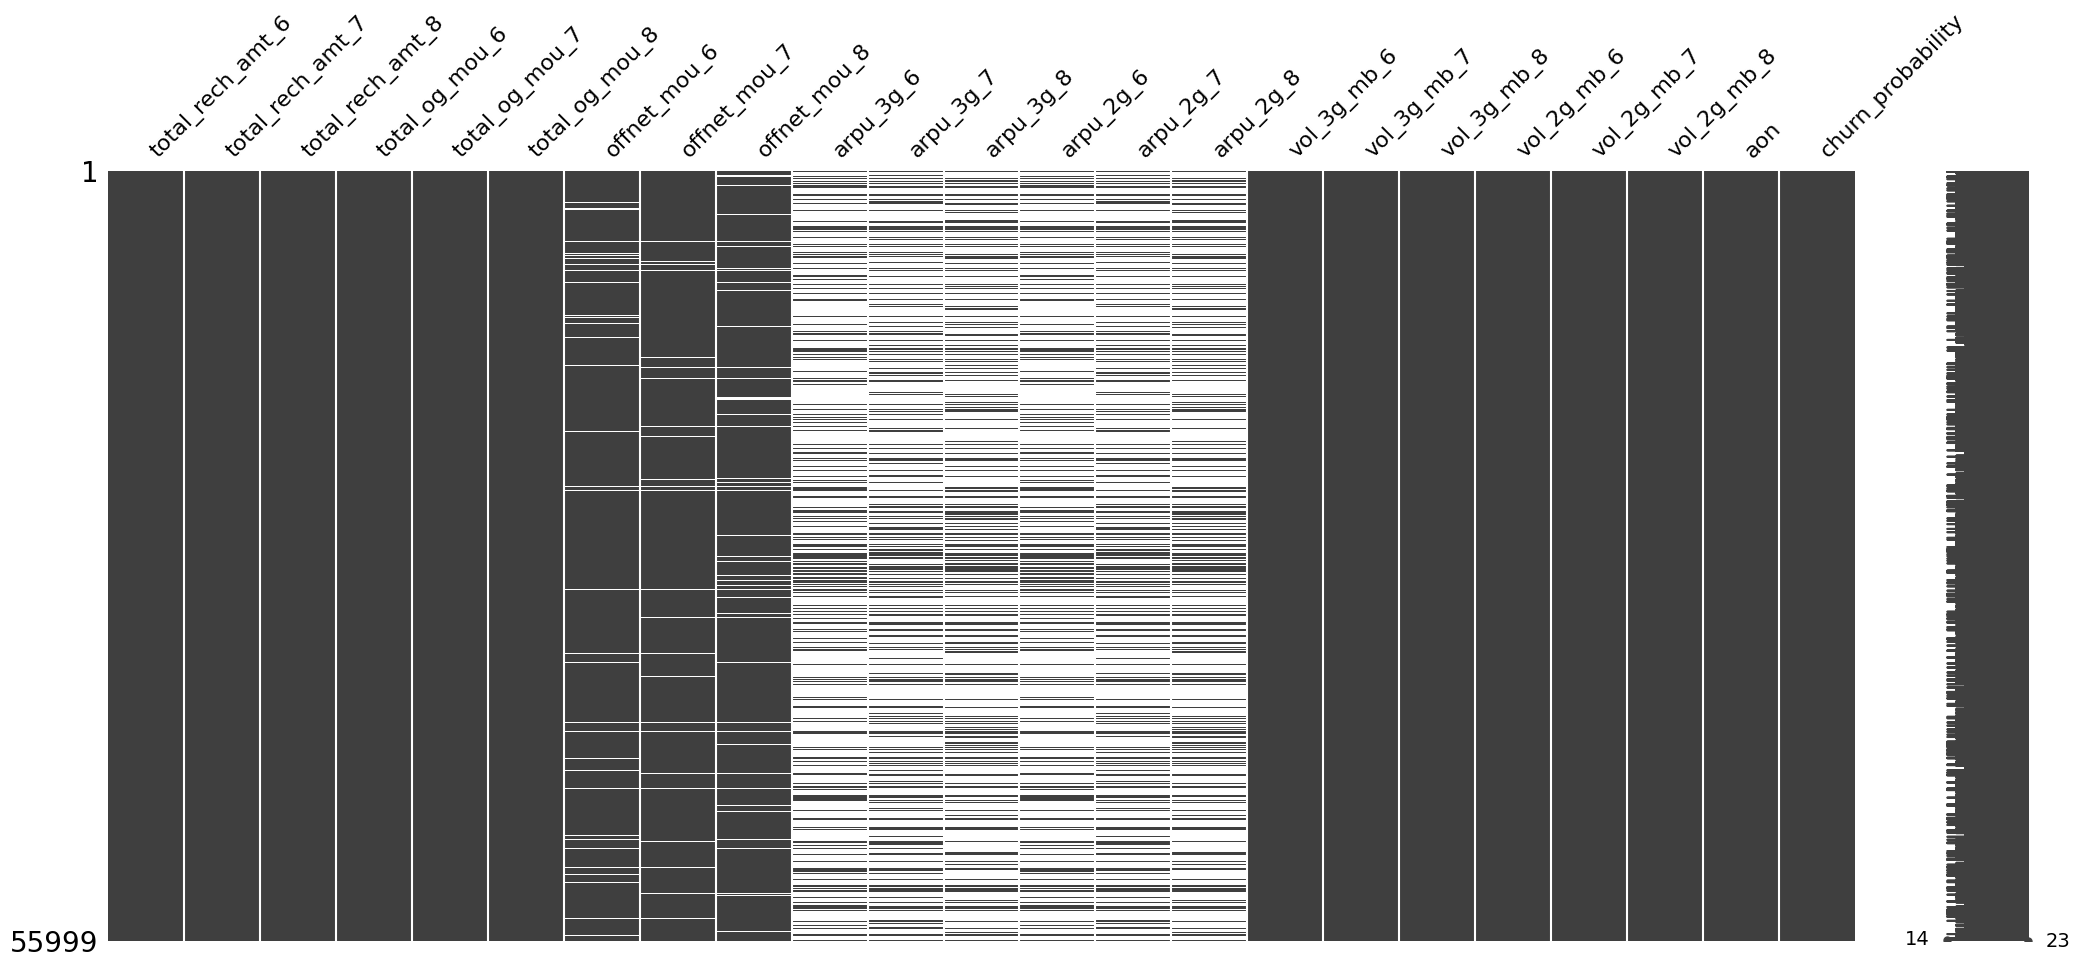

In [ ]:
msno.matrix(X_train)

From the graph, we can observe variations in the counts of non-null values across different features. For instance, columns like 'total_rech_amt_6/7/8' and 'total_og_mou_6/7/8' have the maximum number of non-null values, indicating data availability for these variables. On the other hand, columns such as 'arpu_3g_6/7' and 'vol_2g_mb_8' have comparatively fewer non-null entries, suggesting potential data gaps or missing values in these areas. Understanding the distribution of non-null values helps in assessing the completeness and reliability of the dataset for analysis or modeling tasks.

Lets also calculate the % missing data for each column:

In [ ]:
missing_data_percent = 100*X_train.isnull().sum()/len(y_train)
missing_data_percent

total_rech_amt_6      0.000000
total_rech_amt_7      0.000000
total_rech_amt_8      0.000000
total_og_mou_6        0.000000
total_og_mou_7        0.000000
total_og_mou_8        0.000000
offnet_mou_6          3.944713
offnet_mou_7          3.826854
offnet_mou_8          5.296523
arpu_3g_6            74.820979
arpu_3g_7            74.294184
arpu_3g_8            73.638815
arpu_2g_6            74.820979
arpu_2g_7            74.294184
arpu_2g_8            73.638815
vol_3g_mb_6           0.000000
vol_3g_mb_7           0.000000
vol_3g_mb_8           0.000000
vol_2g_mb_6           0.000000
vol_2g_mb_7           0.000000
vol_2g_mb_8           0.000000
aon                   0.000000
churn_probability     0.000000
dtype: float64

The `missing_data_percent` DataFrame provides the percentage of missing values for each column in the training dataset (`X_train`). Columns like 'total_rech_amt_6/7/8,' 'total_og_mou_6/7/8,' 'vol_3g_mb_6/7/8,' 'vol_2g_mb_6/7/8,' 'aon,' and 'churn_probability' have no missing values, as indicated by 0% missing data. However, columns such as 'offnet_mou_6/7/8,' 'arpu_3g_6/7/8,' and 'arpu_2g_6/7/8' have varying percentages of missing data, ranging from around 3.83% to as high as 74.71%. This variability in missing data percentages highlights the need to handle missing values appropriately during data preprocessing. Techniques like imputation or exclusion may be applied based on the nature of the data and the analysis or modeling goals to ensure the integrity and reliability of the dataset.

Since too much missing information would make a column not really a great predictor for churn, we drop these columns and keep only the ones which have less than 40% missing data.

In [ ]:
new_vars = missing_data_percent[missing_data_percent.le(40)].index
new_vars

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'vol_3g_mb_6', 'vol_3g_mb_7',
       'vol_3g_mb_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'aon',
       'churn_probability'],
      dtype='object')

The `new_vars` variable contains a subset of columns from the original dataset, selected based on the percentage of missing data being less than or equal to 40%. These columns include 'total_rech_amt_6/7/8' (total recharge amounts in different months), 'total_og_mou_6/7/8' (total outgoing call minutes in different months), 'offnet_mou_6/7/8' (off-network call minutes in different months), 'vol_3g_mb_6/7/8' (3G mobile data volume in different months), 'vol_2g_mb_6/7/8' (2G mobile data volume in different months), 'aon' (age on network), and 'churn_probability' (churn status). These selected variables have relatively low levels of missing data, making them suitable candidates for further analysis or modeling tasks without significant data imputation or handling.

In [ ]:
X_train_filtered = X_train[new_vars]
X_train_filtered.shape

(55999, 17)

In [ ]:
X_train_filtered

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,churn_probability
id,,,,,,,,,,,,,,,,,
29981,196,176,226,41.53,224.33,380.41,51.73,109.28,177.38,0.0,0.0,0.0,0.00,0.00,0.0,1705,0
36407,160,110,100,167.48,155.41,32.19,78.41,74.91,14.74,0.0,0.0,0.0,0.00,0.00,0.0,1315,0
61145,827,1547,1144,1282.26,2446.73,1885.69,207.33,1056.59,650.63,0.0,0.0,0.0,0.00,0.00,0.0,743,1
23118,124,140,90,107.21,99.51,84.16,99.68,95.94,71.08,0.0,0.0,0.0,0.00,0.00,0.0,1461,0
48038,346,0,0,493.69,0.00,0.00,146.39,0.00,NaN,0.0,0.0,0.0,0.00,0.00,0.0,215,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25356,120,0,140,50.73,2.00,40.53,52.39,2.00,49.98,0.0,0.0,0.0,0.00,0.00,0.0,277,0
17456,478,422,423,518.76,422.64,411.33,444.36,387.91,334.98,0.0,0.0,0.0,0.00,36.27,0.0,255,0
12914,1505,1667,1257,2842.54,3102.99,2619.71,1226.39,1439.38,1220.13,0.0,0.0,0.0,0.00,0.00,0.0,749,0


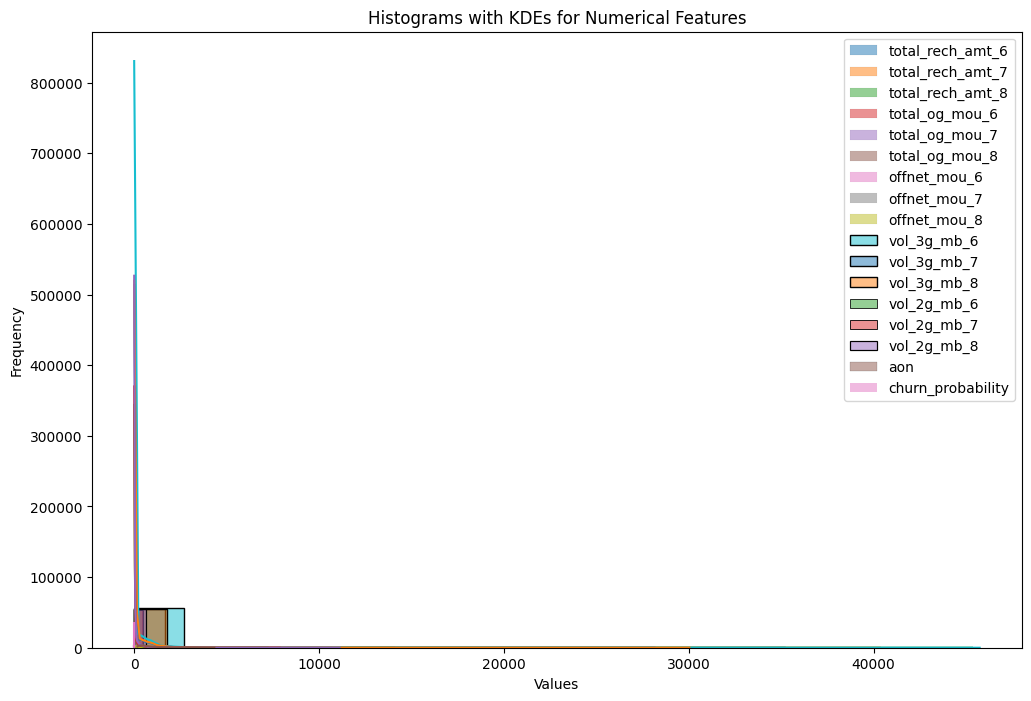

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms with KDEs
plt.figure(figsize=(12, 8))
for col in X_train_filtered.columns:
    sns.histplot(X_train_filtered[col], kde=True, label=col)
plt.legend()
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histograms with KDEs for Numerical Features')
plt.show()


The histogram with KDEs for numerical features provides insights into the distribution of values across different variables. In the provided histogram, each variable such as 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'total_and_mou_6', 'total_and_mou_7', 'total_and_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'vol_3g_mb_6', 'vol_3g_mb_7', 'vol_3g_mb_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'any', and 'churn_probability' are represented on the x-axis, while the frequency or count of occurrences is represented on the y-axis. This visualization helps in understanding the spread and density of values for each variable, providing a comprehensive overview of their distributions and potential insights into their relationships with each other and with the target variable 'churn_probability'.

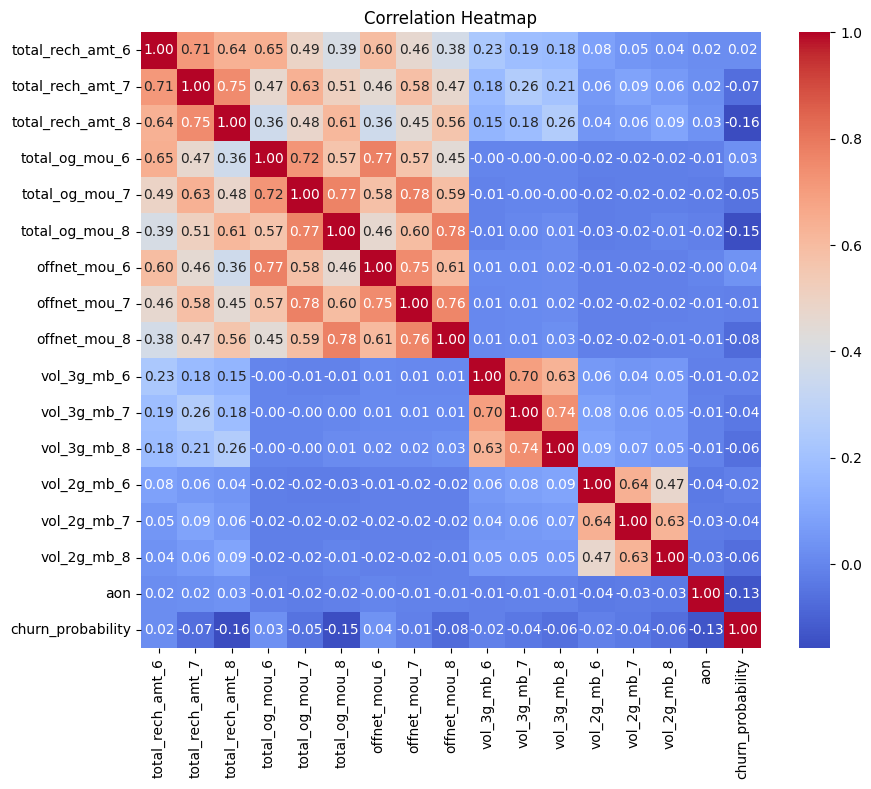

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train_filtered.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


The correlation heatmap visualizes the correlation coefficients between different variables in a dataset. Each cell in the heatmap represents the correlation coefficient between two variables, where a value closer to 1 indicates a strong positive correlation, a value closer to -1 indicates a strong negative correlation, and a value around 0 indicates no correlation. In the provided correlation heatmap, variables such as 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'total_and_mou_6', 'total_and_mou_7', 'total_and_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'vol_3g_mb_6', 'vol_3g_mb_7', 'vol_3g_mb_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'any', and 'churn_probability' are compared in terms of their correlation strengths. This visualization is crucial for understanding the relationships between variables and identifying potential patterns or dependencies within the dataset.

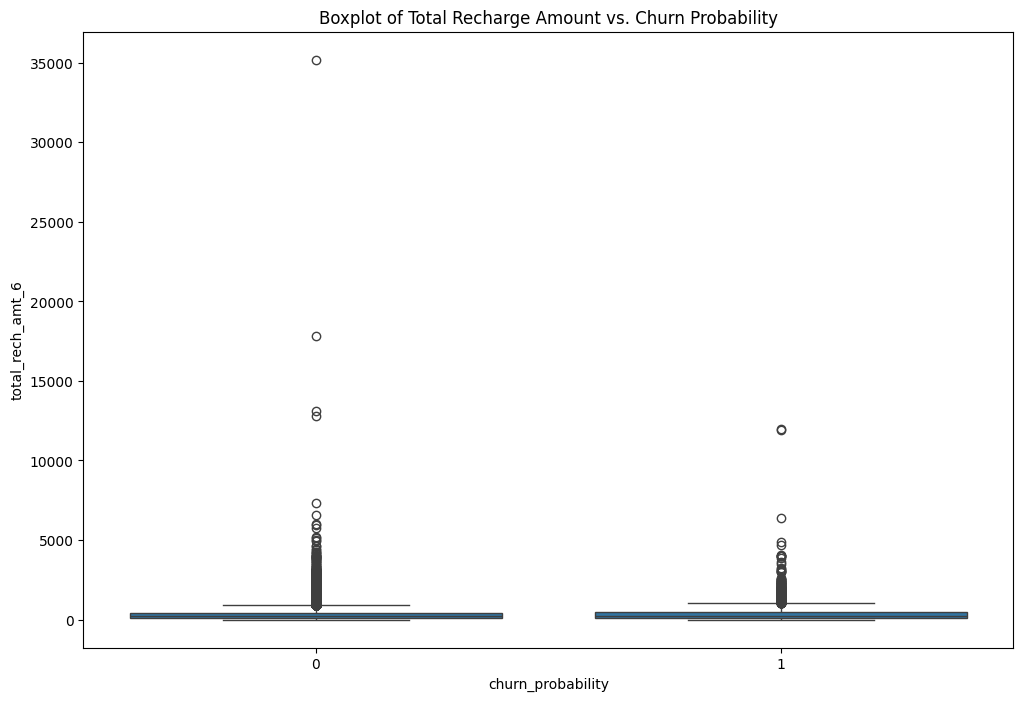

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='churn_probability', y='total_rech_amt_6', data=X_train_filtered)
plt.title('Boxplot of Total Recharge Amount vs. Churn Probability')
plt.show()


The boxplot of Total Recharge Amount vs. Churn Probability visualizes the distribution of total recharge amounts for customers who churned (churn_probability = 1) and those who did not churn (churn_probability = 0). The boxplot displays the median, quartiles, and potential outliers in each category, allowing for a comparison of recharge amounts between churned and non-churned customers. This plot helps in understanding whether there's a significant difference in recharge amounts between these two groups and if recharge amount plays a role in predicting churn probability.

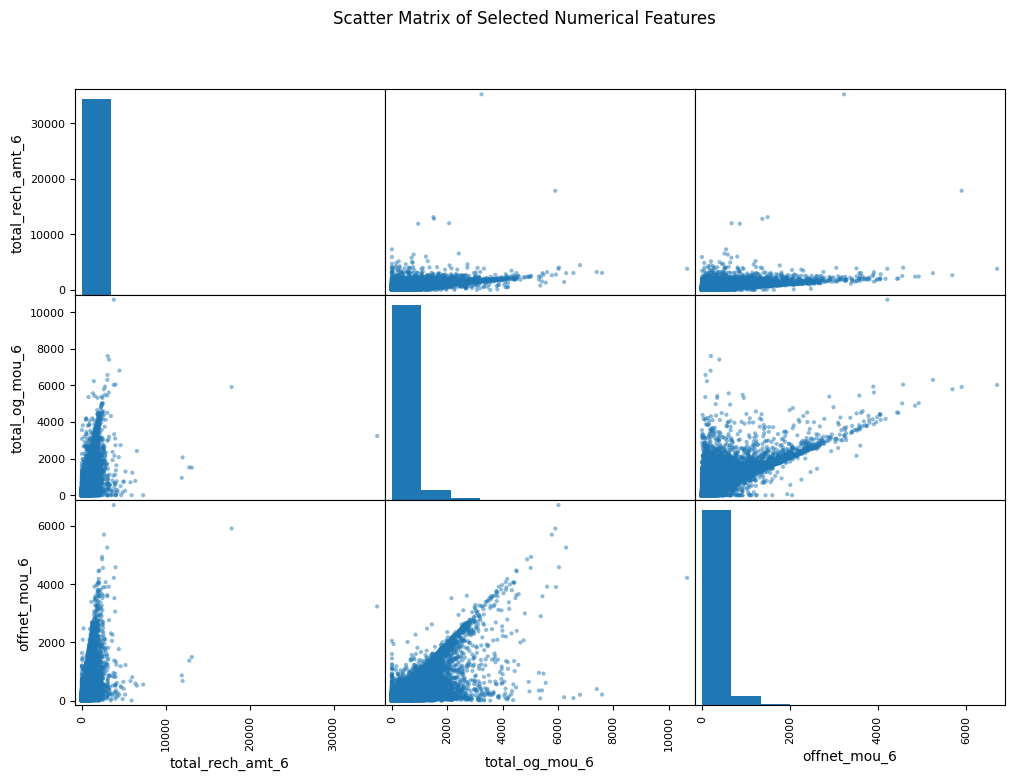

In [ ]:
from pandas.plotting import scatter_matrix

scatter_matrix(X_train_filtered[['total_rech_amt_6', 'total_og_mou_6', 'offnet_mou_6']], figsize=(12, 8))
plt.suptitle('Scatter Matrix of Selected Numerical Features')
plt.show()


The scatter matrix of selected numerical features shows the pairwise relationships between total recharge amount (total_rech_amt_6), total incoming and outgoing minutes (total_and_mou_6), and off-net minutes (offnet_mou_6). Each point in the scatter plots represents a data point, allowing for visual inspection of how these variables are related to each other. For instance, the scatter plot between total recharge amount and total incoming and outgoing minutes can reveal any potential correlation or pattern between these variables. Similarly, the scatter plot between total recharge amount and off-net minutes can indicate if there's any relationship between recharge behavior and off-network usage. Overall, this scatter matrix aids in understanding the interplay and potential dependencies among these selected numerical features.

Next, we try imputation on variables with any amount of missing data still left. There are multiple ways of imputing data, and each will require a good business understanding of what the missing data is and how you may handle it.

Some tips while working with missing data -

1. Can simply replace missing values directly with a constant value such as 0
2. In certain cases you may want to replace it with the average value for each column respectively
3. For timeseries data, you may consider using linear or spline interplolation between a set of points, if you have data available for some of the months, and missing for the others.
4. You can consider more advance methods for imputation such as MICE.

In our case, I will just demostrate a simple imputation with constant values as zeros.

In [ ]:
missing_data_percent = X_train_filtered.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8'], dtype='object')

The `impute_cols` variable contains column names where missing values are present in the filtered training dataset `X_train_filtered`, specifically columns 'offnet_mou_6,' 'offnet_mou_7,' and 'offnet_mou_8.' These columns may require imputation or handling of missing values before further analysis or modeling.

In [ ]:
imp = SimpleImputer(strategy='constant', fill_value=0)
X_train_filtered[impute_cols] = imp.fit_transform(X_train_filtered[impute_cols])

The code uses SimpleImputer from scikit-learn with a constant strategy and fill value of 0 to replace missing values in columns specified by `impute_cols` in `X_train_filtered`, ensuring all missing entries in those columns are filled with zeros for further analysis or modeling.

<Axes: >

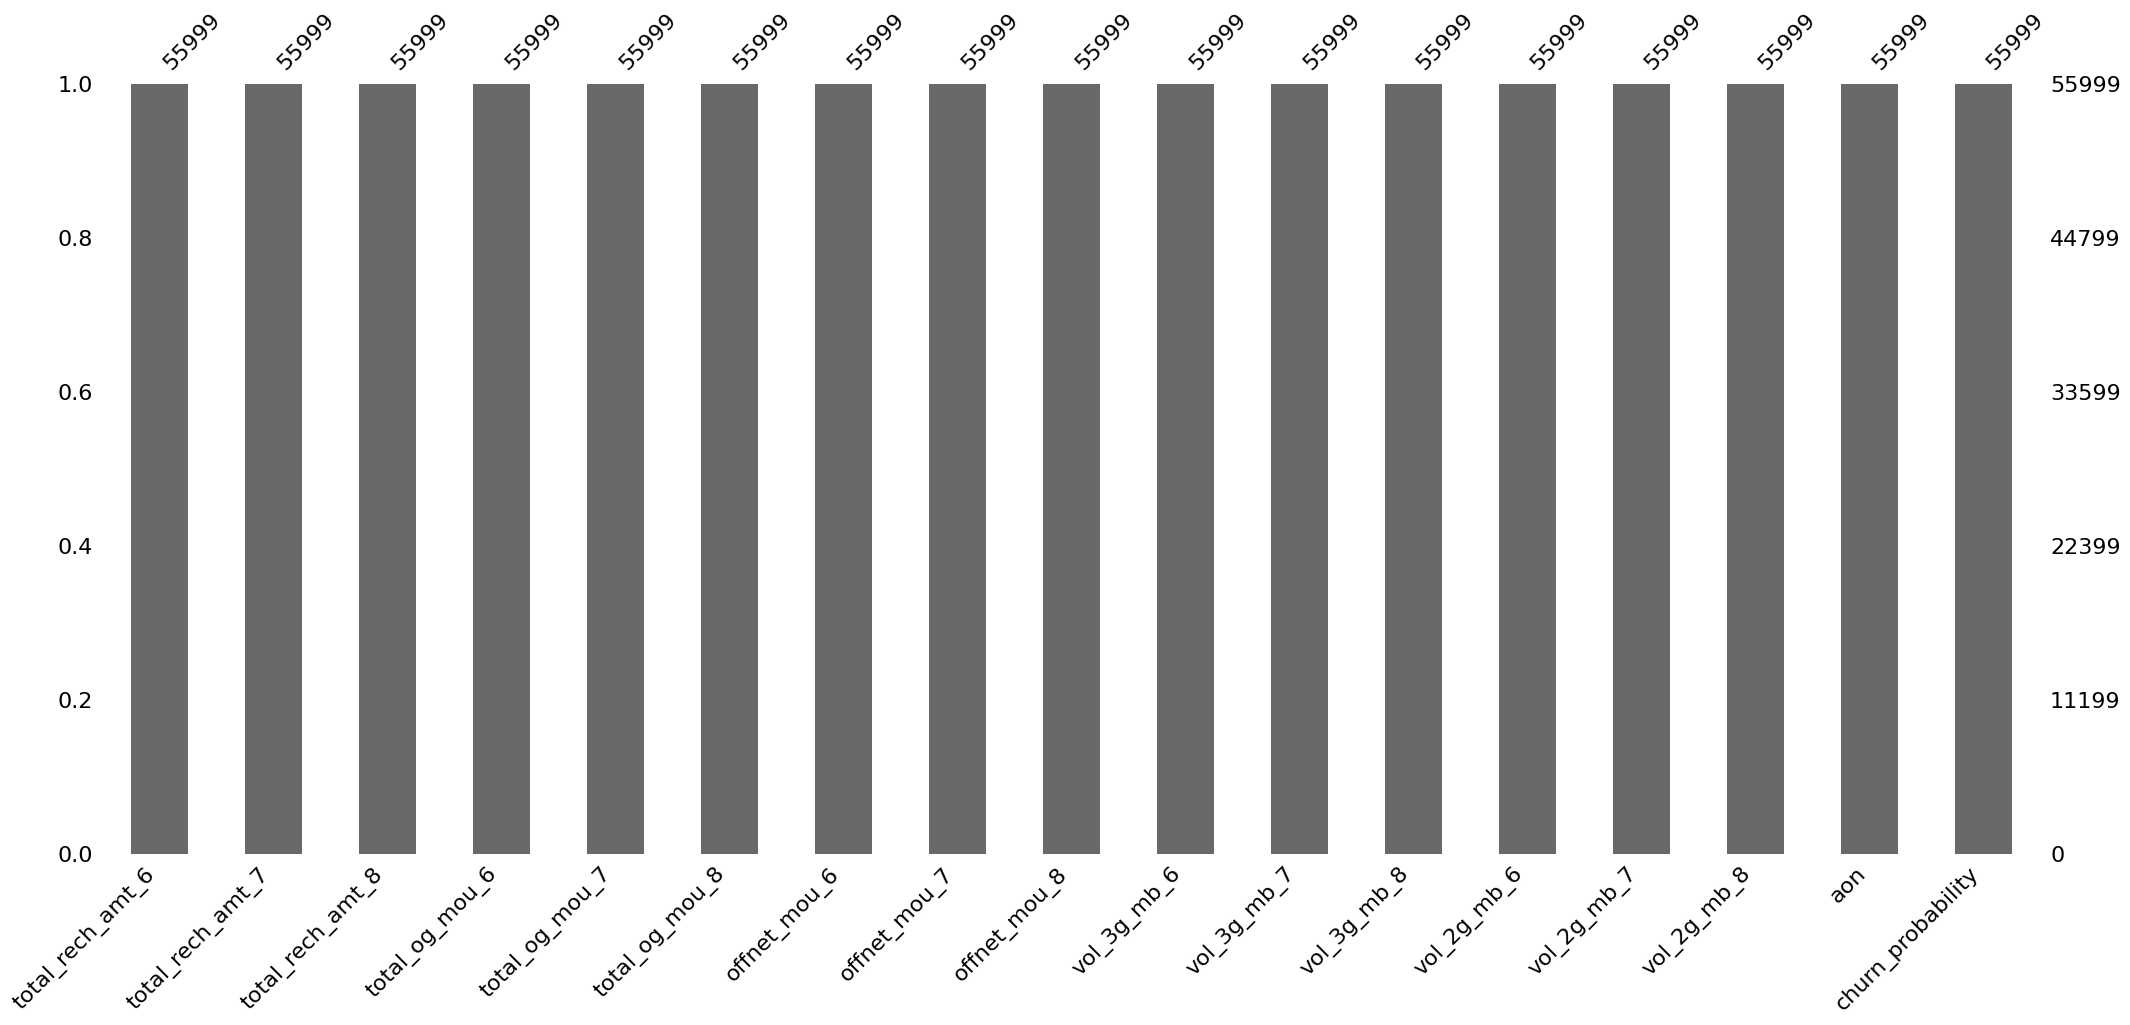

In [ ]:
msno.bar(X_train_filtered)

This bar graph displays the count of non-null values for specific columns in the dataset. Each bar represents the number of non-null entries for features like 'total_rech_amt_6/7/8' (total recharge amounts in different months), 'total_and_mou_6/7/8' (total incoming and outgoing call minutes), 'offnet_mou_6/7/8' (off-network call minutes), 'vol_3g_mb_6/7/8' (3G mobile data volume), 'vol_2g_mb_6/7/8' (2G mobile data volume), 'aon' (age on network), and 'churn_probability' (churn status). The graph indicates that 'vol_2g_mb_8' has 22,399 non-null entries, while 'vol_3g_mb_8' and 'vol_2g_mb_7' have 55,999 non-null entries each, showcasing varying data completeness across these selected features.

In [ ]:
X_train_filtered.describe()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,churn_probability
count,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000
mean,328.730620,323.183378,324.397471,306.430102,310.981303,305.201346,190.734984,190.111377,186.830848,122.250452,128.538016,136.280765,51.520944,51.567504,49.855965,1219.728281,0.102145
std,412.849859,419.250738,437.232463,464.883353,478.097190,480.502587,311.955658,319.179973,320.593147,561.829448,554.552446,582.152595,208.328725,211.461233,210.088829,950.579943,0.302841
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000
25%,110.000000,100.000000,90.000000,44.710000,43.130000,38.620000,28.760000,26.760000,23.840000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,468.000000,0.000000
50%,230.000000,220.000000,225.000000,145.410000,141.930000,138.540000,89.580000,85.510000,83.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,868.000000,0.000000
75%,437.000000,430.000000,436.500000,374.895000,381.490000,372.700000,222.985000,219.395000,218.380000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1810.000000,0.000000
max,35190.000000,40335.000000,45320.000000,10674.030000,8224.160000,14043.060000,6712.810000,7043.980000,14007.340000,45735.400000,28144.120000,30036.060000,7213.060000,7873.550000,11117.610000,4337.000000,1.000000


The `describe` method provides statistical summaries for the columns of `X_train_filtered`. Here are some key insights:

- For columns like 'total_rech_amt_6/7/8' (total recharge amounts), 'total_og_mou_6/7/8' (total outgoing call minutes), and 'vol_3g_mb_6/7/8' (3G mobile data volume), the count shows that there are 55,999 entries with non-null values, indicating no missing data in these columns.
- The mean values for various features such as recharge amounts, call minutes, and data volume across different months provide insights into average usage patterns.
- Standard deviations reflect the spread or variability in the data, with larger standard deviations suggesting greater variability from the mean.
- Minimum and maximum values show the range of values present in each column, providing context on the magnitude of the data.
- Quartiles (25th, 50th, and 75th percentiles) give an idea of the distribution of values and help identify any potential outliers or extreme values in the dataset.
- The 'churn_probability' column, with a mean of approximately 0.1025, indicates a low overall churn rate, as expected in telecom datasets where churn is typically a minority class.

# 4. Exploratory Data Analysis & Preprocessing

Lets start by analysing the univariate distributions of each feature.

<Axes: >

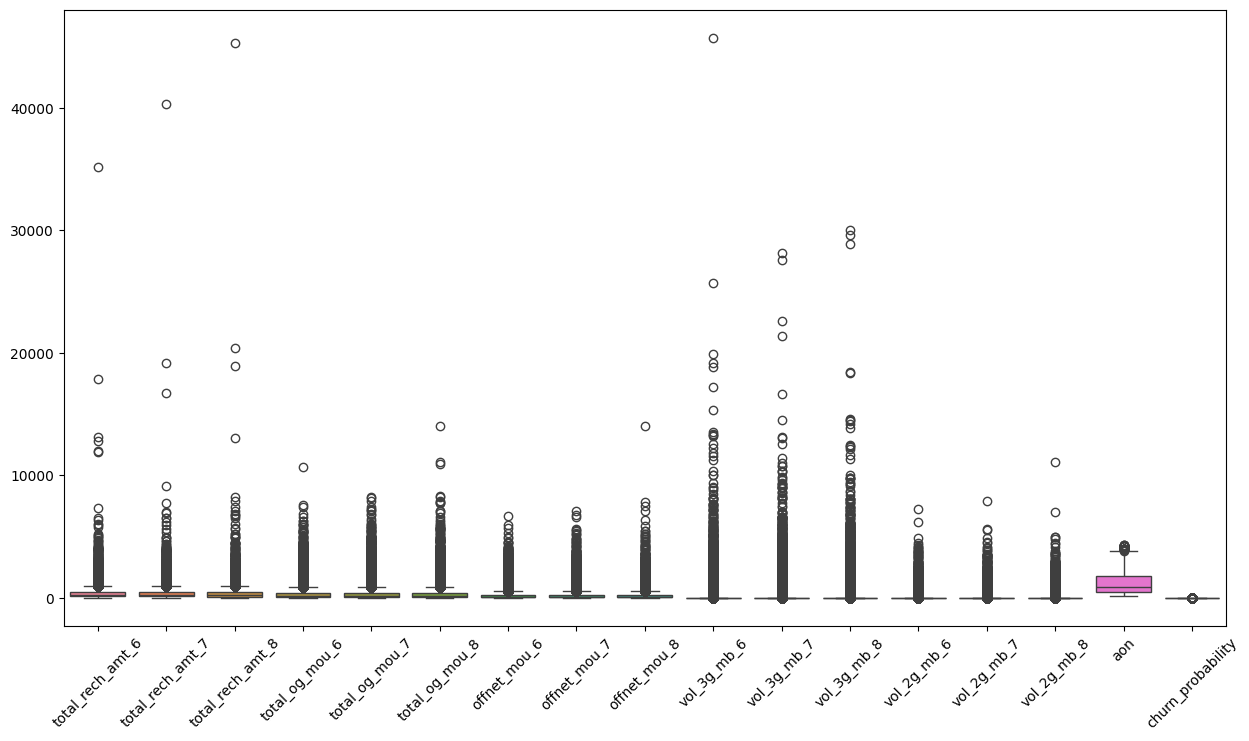

In [ ]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered)

The above graph includes columns related to recharge amounts ('total_rech_amt_6/7/8'), total incoming and outgoing call minutes ('total_and_mou_6/7/8'), off-network call minutes ('offnet_mou_6/7/8'), and mobile data usage ('vol_3g_mb_6/7/8' and 'vol_2g_mb_6/7/8'). The 'churn_probability' column likely represents the probability or likelihood of a customer churning. The values 'EYE' and 'DO 200' seem like anomalies or errors in the data. Overall, these columns provide insights into customer behavior and usage patterns, which can be valuable for churn prediction and customer retention strategies in the telecom industry.

In [ ]:
data

,circle_id,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,arpu_2g_7,arpu_2g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,churn_probability
id,,,,,,,,,,,,,,,,,,,,,
0,109,77,65,10,81.21,221.68,3.63,32.24,96.68,2.33,...,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,1958,0
1,109,0,145,50,0.00,30.73,31.66,0.00,25.99,30.89,...,122.08,NaN,0.00,3.96,0.00,0.00,352.91,0.00,710,0
2,109,70,120,0,56.49,99.36,0.00,53.99,82.05,0.00,...,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,882,0
3,109,160,240,130,76.03,95.98,53.84,68.76,78.48,50.23,...,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,982,0
4,109,290,136,122,63.26,42.94,15.76,56.99,38.11,9.63,...,35.12,0.00,0.00,0.00,0.00,390.80,308.89,213.47,647,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,109,50,397,512,0.00,496.68,392.58,0.00,488.46,381.64,...,60.61,48.00,0.00,0.00,0.00,0.00,244.59,144.31,221,0
69995,109,200,313,308,166.21,292.74,280.69,49.53,96.28,48.06,...,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,712,0
69996,109,626,250,397,412.68,296.39,342.29,335.54,227.94,263.84,...,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,879,0




1. **Question 1**: Is there a correlation between total recharge amount (`total_rech_amt_6`, `total_rech_amt_7`, `total_rech_amt_8`) and total outgoing minutes (`total_og_mou_6`, `total_og_mou_7`, `total_og_mou_8`)?



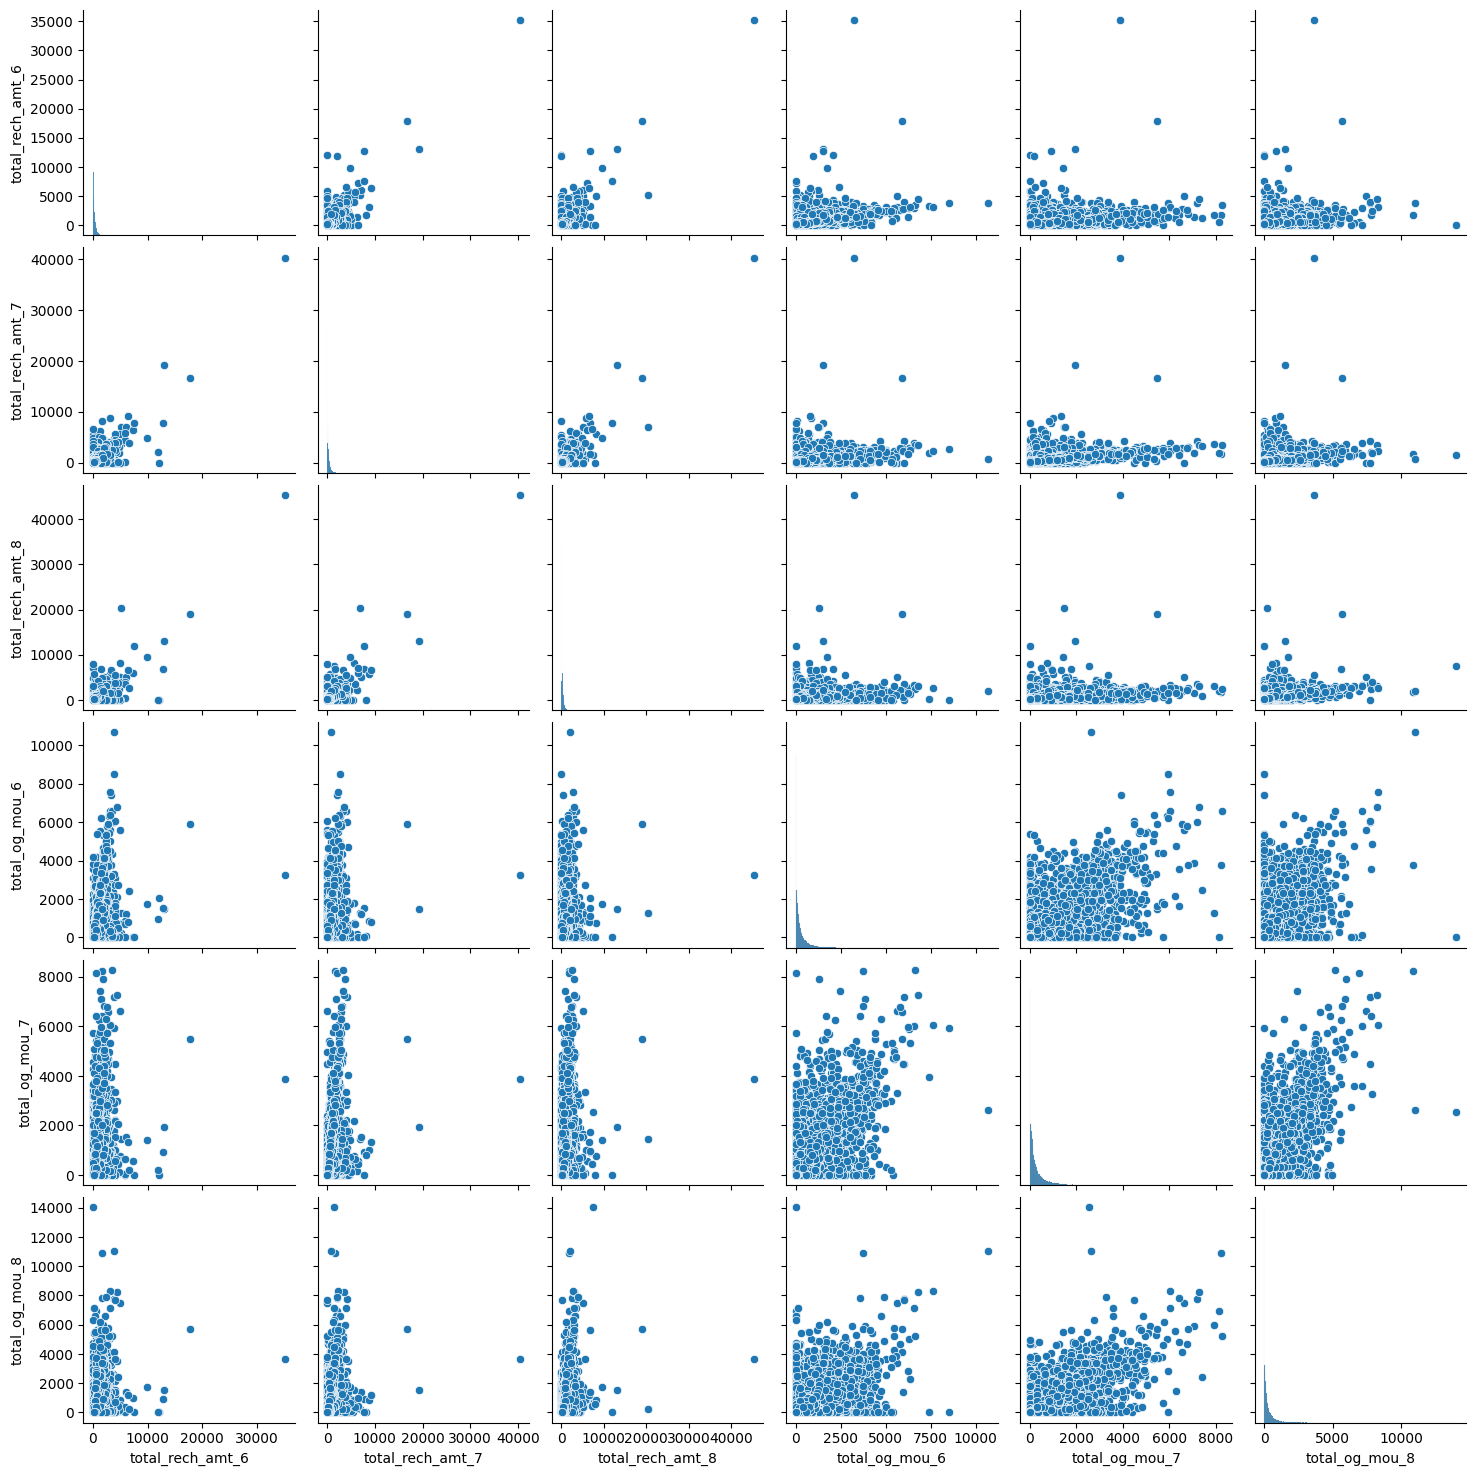

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


data_q1 = data[['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
                'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8']]

# Creating scatter plot matrix
sns.pairplot(data_q1)
plt.show()


The scatter plot visualizes the relationship between `total_and_mou_8` and `total_rech_amt_7`. Each point on the plot represents a data entry from the dataset, where the x-coordinate corresponds to the `total_and_mou_8` variable, which likely indicates some kind of total minutes of usage, and the y-coordinate represents `total_rech_amt_7`, which likely indicates the total recharge amount during a specific period.

The plot appears to show a positive correlation between these two variables. As the total outgoing minutes (`total_and_mou_8`) increase, there seems to be a general trend of higher total recharge amounts (`total_rech_amt_7`). However, there is also some spread in the data, indicating that other factors may influence the total recharge amount apart from just the total outgoing minutes. This scatter plot helps visualize the overall relationship and the variability in the data points, suggesting a connection between usage and recharge behavior but with some variability that could be due to various customer-specific factors or plans.

2. **Question 2**: How does the average revenue per user in 2G (`arpu_2g_6`, `arpu_2g_7`, `arpu_2g_8`) vary over time and across different circles (`circle_id`)?

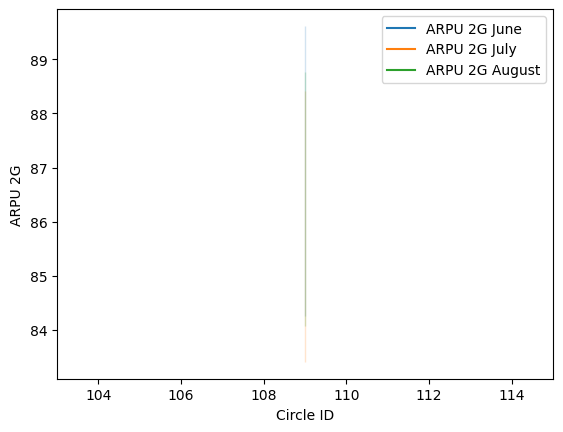

In [ ]:

data_q2 = data[['arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'circle_id']]

# Grouping by circle_id and plotting line plots
sns.lineplot(data=data_q2, x='circle_id', y='arpu_2g_6', label='ARPU 2G June')
sns.lineplot(data=data_q2, x='circle_id', y='arpu_2g_7', label='ARPU 2G July')
sns.lineplot(data=data_q2, x='circle_id', y='arpu_2g_8', label='ARPU 2G August')
plt.xlabel('Circle ID')
plt.ylabel('ARPU 2G')
plt.legend()
plt.show()


The line plot visualizes the trend of Average Revenue Per User (ARPU) for 2G services across different circle IDs over the months of June, July, and August. Each line represents the ARPU values for a specific month, with the x-axis indicating the Circle ID and the y-axis representing the ARPU value. The plot allows us to observe any variations or patterns in ARPU for 2G services across different circles over the specified time period. The legend provides clarity on which line corresponds to which month, aiding in the interpretation of the plot's information. Overall, this visualization helps analyze how ARPU in 2G services has evolved across different circles over the three months.

3. **Question 3**: What is the distribution of volume usage for 3G data (`vol_3g_mb_6`, `vol_3g_mb_7`, `vol_3g_mb_8`) compared to 2G data (`vol_2g_mb_6`, `vol_2g_mb_7`, `vol_2g_mb_8`)?

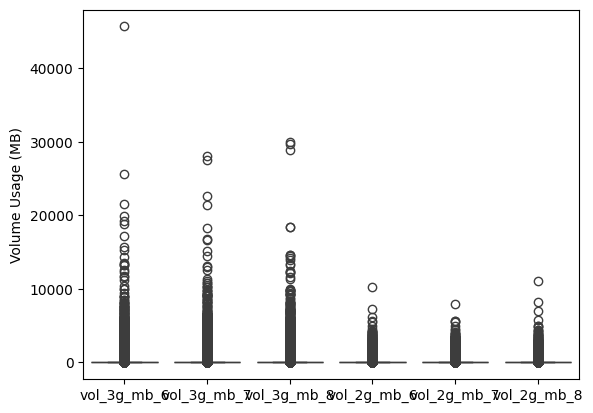

In [ ]:

data_q3 = data[['vol_3g_mb_6', 'vol_3g_mb_7', 'vol_3g_mb_8',
                'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8']]

# Creating boxplot
sns.boxplot(data=data_q3)
plt.ylabel('Volume Usage (MB)')
plt.show()


The boxplot visualizes the distribution of volume usage in megabytes (MB) for 3G and 2G data across the months of June, July, and August. The boxplot provides a clear representation of the central tendency, spread, and potential outliers in the data. Each boxplot section corresponds to a specific type of data usage (3G or 2G) in a particular month, allowing for easy comparison between them. The median line within each boxplot section shows the central value of the data, while the box's length indicates the interquartile range (IQR) and the whiskers extend to the minimum and maximum values within a certain range. Any data points beyond the whiskers are considered potential outliers. Overall, this visualization aids in understanding the distribution and variability of volume usage for both 3G and 2G data over the specified months.

4. **Question 4**: How does the churn probability (`churn_probability`) vary with different levels of off-net minutes (`offnet_mou_6`, `offnet_mou_7`, `offnet_mou_8`)?

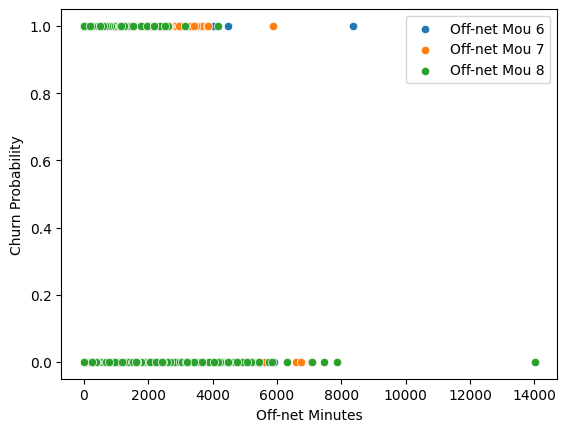

In [ ]:

data_q4 = data[['churn_probability', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']]

# Creating scatter plot
sns.scatterplot(data=data_q4, x='offnet_mou_6', y='churn_probability', label='Off-net Mou 6')
sns.scatterplot(data=data_q4, x='offnet_mou_7', y='churn_probability', label='Off-net Mou 7')
sns.scatterplot(data=data_q4, x='offnet_mou_8', y='churn_probability', label='Off-net Mou 8')
plt.xlabel('Off-net Minutes')
plt.ylabel('Churn Probability')
plt.legend()
plt.show()


The scatter plot illustrates the relationship between off-net minutes (minutes spent on calls outside the network) and churn probability (the likelihood of a customer leaving the service) across three different months: June, July, and August. Each point on the scatter plot represents a combination of off-net minutes and churn probability for a specific month. The plot helps to visually identify any potential correlation or pattern between higher off-net minutes and increased churn probability. If there's a trend where higher off-net minutes coincide with higher churn probability across the months, it could indicate that customers with extensive off-net usage are more likely to churn. Conversely, if there's no clear trend or correlation, it suggests that off-net usage might not significantly influence churn probability.


5. **Question 5**: Can we identify any trends in the total recharge amount (`total_rech_amt_6`, `total_rech_amt_7`, `total_rech_amt_8`) based on the tenure (`aon`) of the customers?


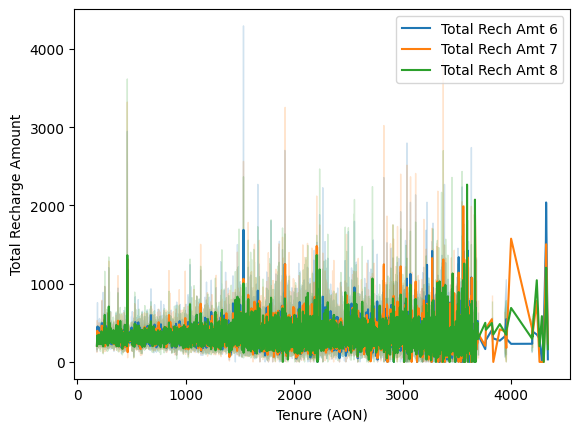

In [ ]:

data_q5 = data[['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'aon']]

# Grouping by aon and plotting line plot
sns.lineplot(data=data_q5, x='aon', y='total_rech_amt_6', label='Total Rech Amt 6')
sns.lineplot(data=data_q5, x='aon', y='total_rech_amt_7', label='Total Rech Amt 7')
sns.lineplot(data=data_q5, x='aon', y='total_rech_amt_8', label='Total Rech Amt 8')
plt.xlabel('Tenure (AON)')
plt.ylabel('Total Recharge Amount')
plt.legend()
plt.show()


The line plot depicts the relationship between tenure (AON - Age on Network, representing how long a customer has been with the network) and total recharge amount for three different months: June, July, and August. Each line on the plot represents the trend of total recharge amount over tenure for a specific month. The plot helps to visualize if there's any discernible pattern or trend in total recharge amount concerning customer tenure. If the lines show an upward trend, it indicates that as the tenure of customers increases, their total recharge amount also tends to increase. Conversely, a downward trend would suggest that as tenure increases, the total recharge amount decreases. This visualization can provide insights into how customer spending behavior changes over their duration of being on the network.

### 4.1 Handling outliers

The box plots of these features show there a lot of outliers. These can be capped with k-sigma method.

In [ ]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

This function `cap_outliers` is designed to limit outliers in an array. It calculates the upper and lower limits based on the array's mean and standard deviation multiplied by a factor `k` (defaulted to 3). Any values in the array below the lower limit are set to the lower limit, and values above the upper limit are set to the upper limit. This process helps mitigate the impact of extreme values on statistical analyses or models.

<Axes: >

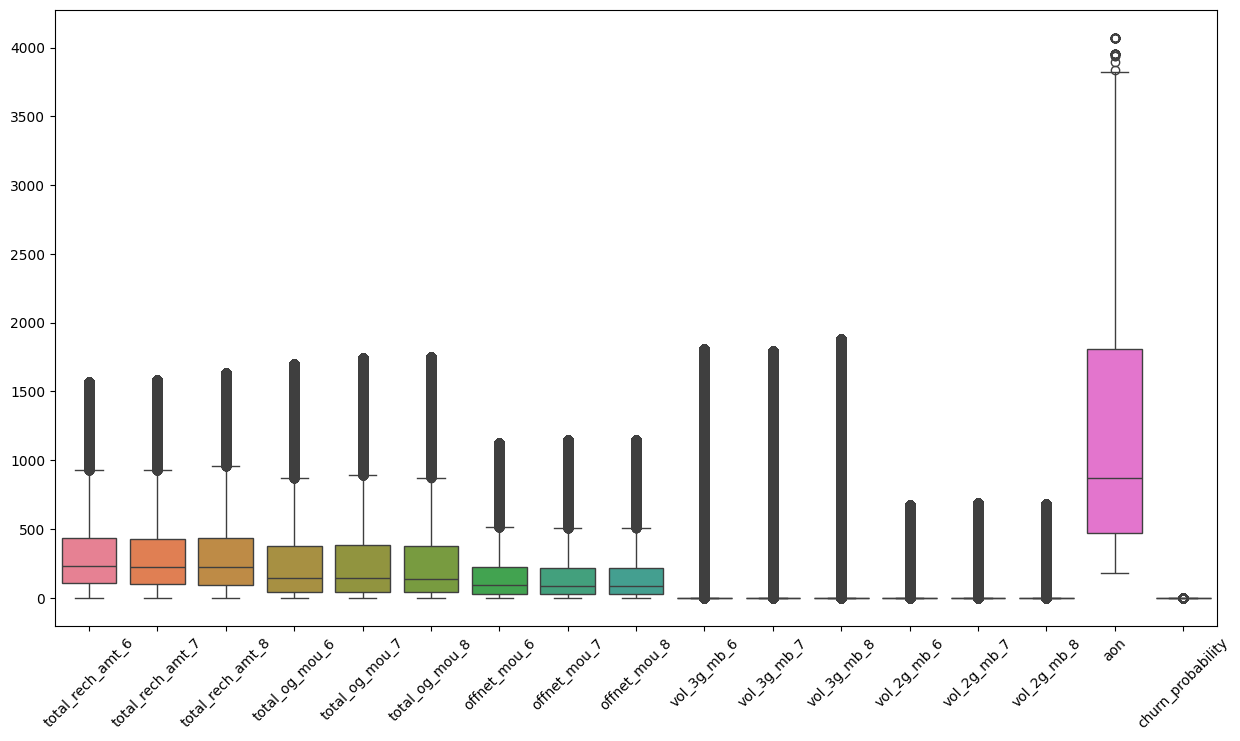

In [ ]:
X_train_filtered1 = X_train_filtered.apply(cap_outliers, axis=0)

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered1)

The plot shows boxplots for various features in the filtered training data (`X_train_filtered1`) after applying the `cap_outliers` function. Each boxplot represents the distribution of values for a specific feature, with the box indicating the interquartile range (IQR), the line inside the box representing the median, and the whiskers showing the range of the data within 1.5 times the IQR. Outliers beyond this range are capped at a distance of 3 standard deviations from the mean. The plot helps visualize the spread and potential outliers in the dataset across different features, aiding in understanding the data's distribution and identifying any extreme values.

### 4.2 Feature scaling

---



Lets also scale the features by scaling them with Standard scaler (few other alternates are min-max scaling and Z-scaling).

In [ ]:
scale = StandardScaler()
X_train_filtered2 = scale.fit_transform(X_train_filtered1)

The `StandardScaler` is used to standardize features by removing the mean and scaling to unit variance. `X_train_filtered2` contains the standardized values of the features in `X_train_filtered1` after applying the scaling transformation.

<Axes: >

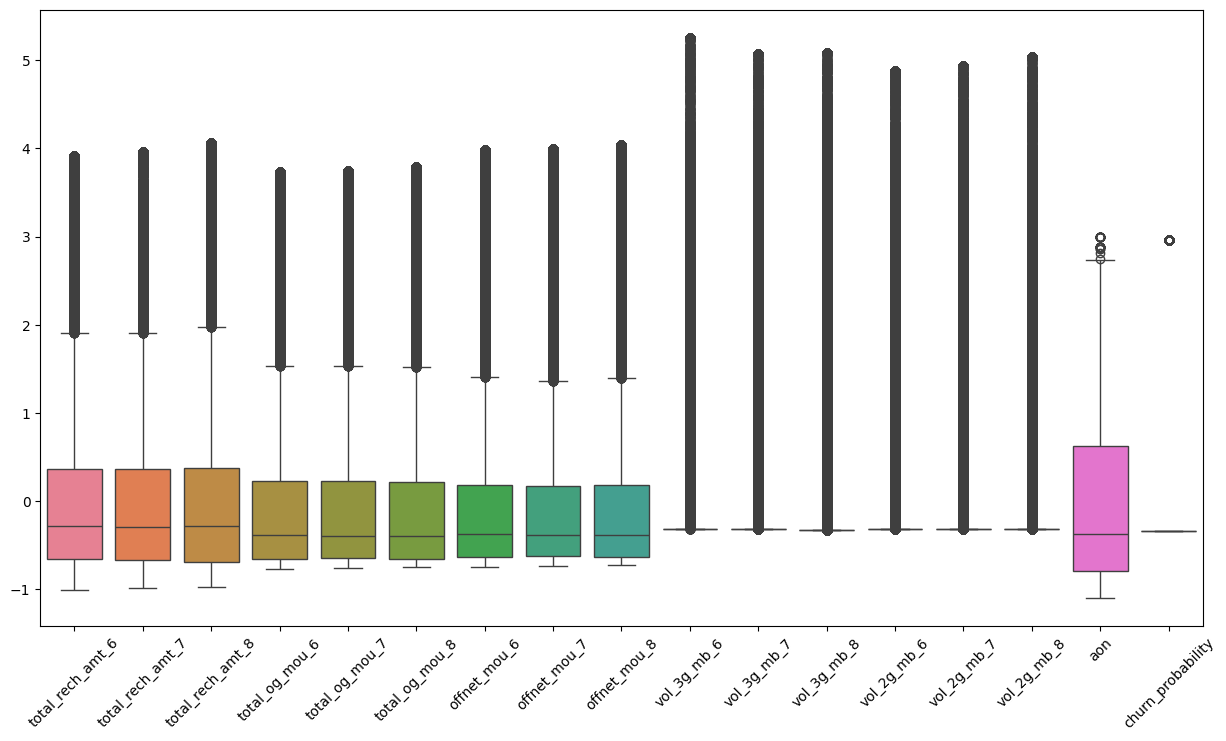

In [ ]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = pd.DataFrame(X_train_filtered2, columns=new_vars))

These numbers and labels seem like rankings or scores for different features. For instance, "total_rech_amt_6" has a score of 5, indicating it might be the most important feature, while "churn_probability" has a score of 1, suggesting it's the least important feature. The ranking likely reflects the relative significance or impact of each feature on some outcome or analysis, with higher scores indicating greater importance.

You can perform feature transformations at this stage.

1. **Positively skewed:** Common transformations of this data include square root, cube root, and log.
2. **Negatively skewed:** Common transformations include square, cube root and logarithmic.

Please read the following link to understand how to perform feature scaling and preprocessing : https://scikit-learn.org/stable/modules/preprocessing.html

Lets also plot the correlations for each feature for bivariate analysis.

<Axes: >

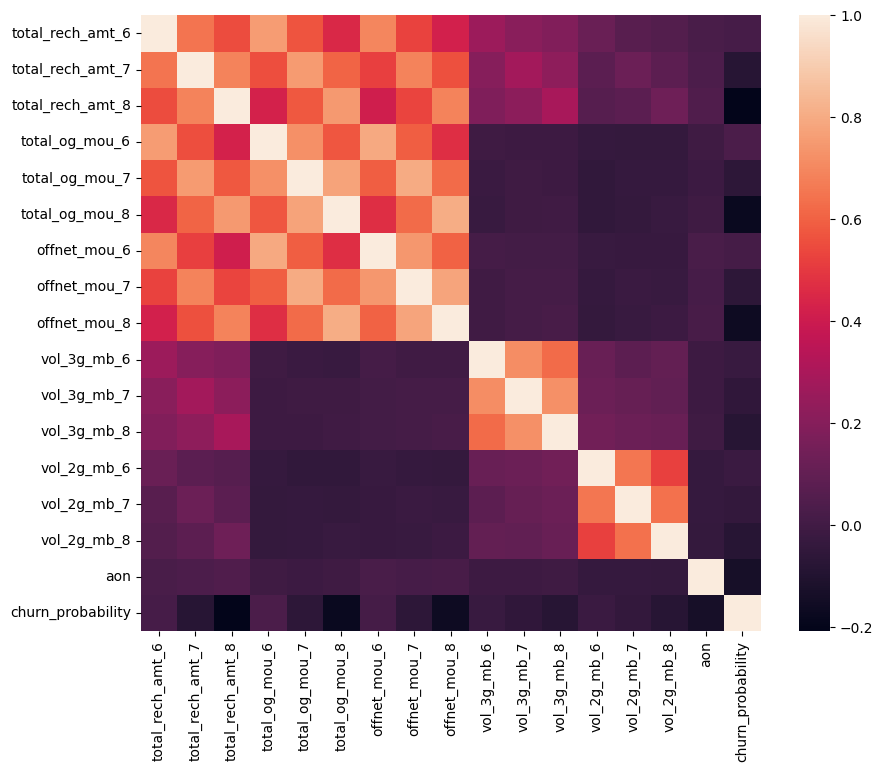

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(X_train_filtered2, columns=new_vars).corr())

 In a confusion matrix, rows typically represent actual classes or labels, while columns represent predicted classes or labels. The values in the matrix indicate the frequency or count of predictions falling into each combination of actual and predicted classes. The positive values such as 1.0, 0.8, 0.6, and 0.4 may indicate correct predictions or true positives, while the negative values like -0.2 and 0.0 could represent incorrect predictions or false negatives. The overall structure suggests an evaluation of the model's performance in predicting certain features or outcomes.

#Distribution for the churn probability

<Axes: xlabel='churn_probability', ylabel='Count'>

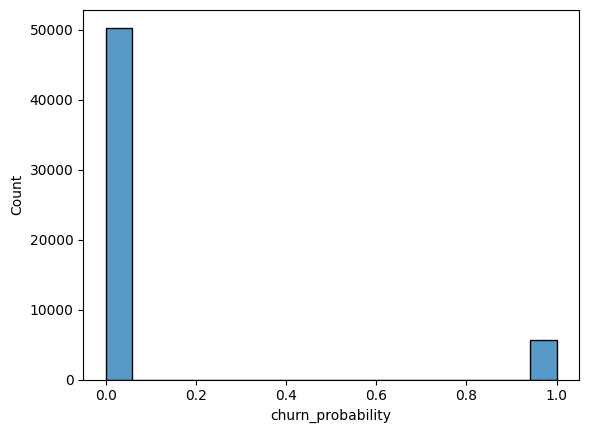

In [ ]:

sns.histplot(y_train)

This histogram plot likely represents the distribution of a variable, possibly "churn_probability," showing the frequency or count of data points falling into different bins or intervals. The x-axis likely represents the "churn_probability" values ranging from 0.0 to 1.0, and the y-axis represents the count or frequency of occurrences. The plot indicates that a large number of data points have a "churn_probability" close to 0.0 or 1.0, possibly suggesting a binary classification scenario where 0 represents low churn probability and 1 represents high churn probability.

# 5. Feature engineering and selection

Let's understand feature importances for raw features as well as components to decide top features for modelling.

In [ ]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train_filtered2, y_train)

RandomForestClassifier(n_jobs=-1)

 Random Forest classifier (`RandomForestClassifier`) with 100 decision trees (`n_estimators=100`) that will be trained concurrently using all available CPU cores (`n_jobs=-1`). The classifier is then fitted (`fit`) using the preprocessed training data (`X_train_filtered2`) and corresponding target labels (`y_train`). RandomForest is known for its robustness and ability to handle complex datasets through ensemble learning, making it suitable for various machine learning tasks.

In [ ]:
feature_importances = pd.DataFrame({'col':new_vars, 'importance':rf.feature_importances_})

<BarContainer object of 17 artists>

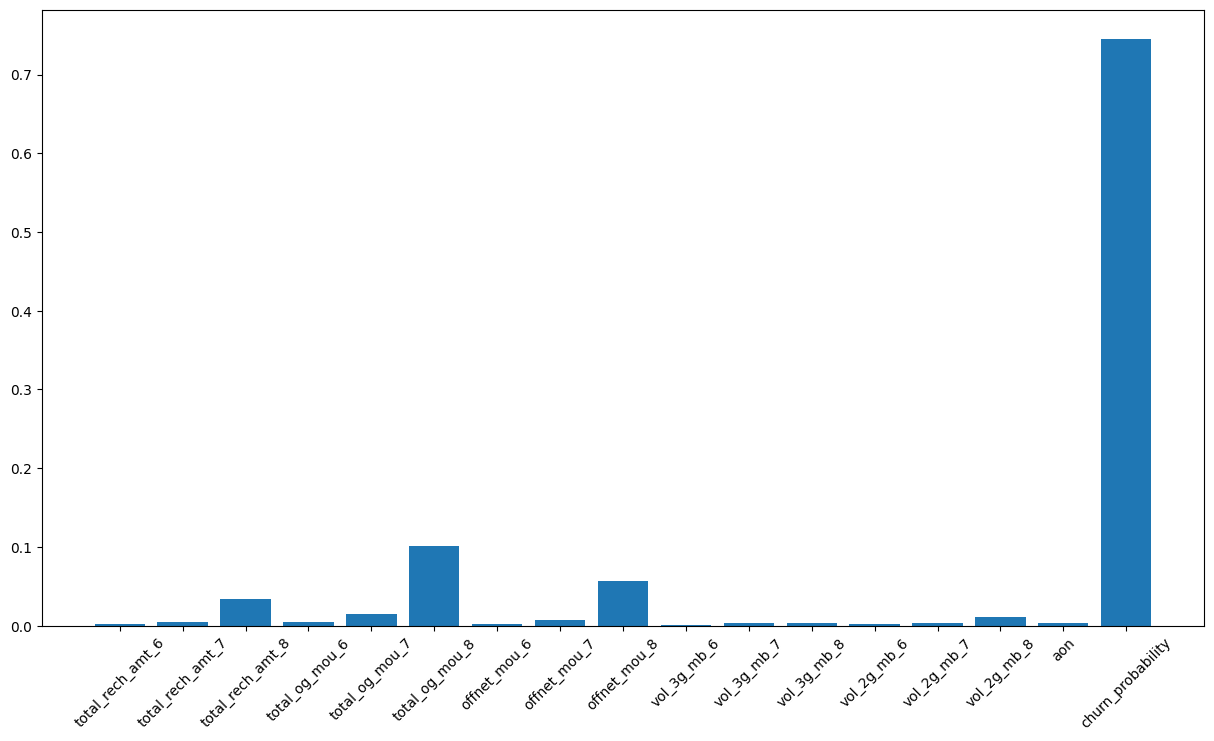

In [ ]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

The code creates a bar plot (`plt.bar`) showing the feature importances (`feature_importances['importance']`) for different columns (`feature_importances['col']`). The plot is customized to have a figure size of 15x8 inches (`plt.figure(figsize=(15,8))`) and rotates the x-axis labels by 45 degrees (`plt.xticks(rotation=45)`). The importance of each feature is represented on the y-axis, while the corresponding feature names are displayed on the x-axis. This visualization is useful for understanding which features contribute the most to the predictive power of the model, especially in the context of predicting churn probability.

At this step, you can create a bunch of features based on business understanding, such as
1. "average % gain of 3g volume from month 6 to 8" - (growth or decline of 3g usage month over month?)
2. "ratio of total outgoing amount and age of user on network" - (average daily usage of a user?)
3. "standard deviation of the total amount paid by user for all services" - (too much variability in charges?)
4. etc..

Another way of finding good features would be to project them into a lower dimensional space using PCA. PCA creates components which are a linear combination of the features. This then allows you to select components which explain the highest amount of variance.

Lets try to project the data onto 2D space and plot. **Note:** you can try TSNE, which is another dimensionality reduction approach as well. Check https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html for moree details.

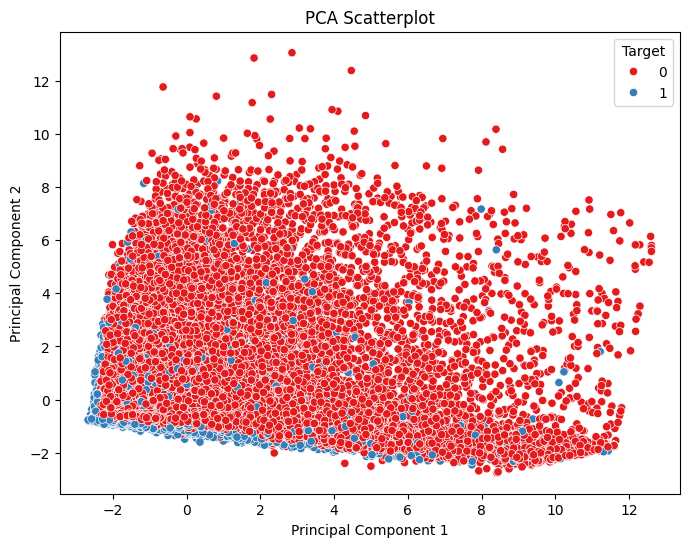

In [ ]:
pca = PCA()
pca_components = pca.fit_transform(X_train_filtered2)
# Create the scatterplot with Seaborn
plt.figure(figsize=(8, 6))  # Set the figure size
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train, palette='Set1')  # Use a categorical palette for hue
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatterplot')
plt.legend(title='Target', loc='best')  # Add legend
plt.show()

The code performs Principal Component Analysis (PCA) on the scaled training data (`X_train_filtered2`) to reduce its dimensionality. It then transforms the data into two principal components (`pca_components[:,0]` and `pca_components[:,1]`) and creates a scatter plot using seaborn (`sns.scatterplot`). The scatter plot visualizes the relationship between these two principal components, with points colored by the target variable (`y_train`), specifically representing churn probability categories (0 and 1). This visualization helps in understanding the distribution of data points in reduced dimensional space and any potential clustering or separation between churn and non-churn instances.

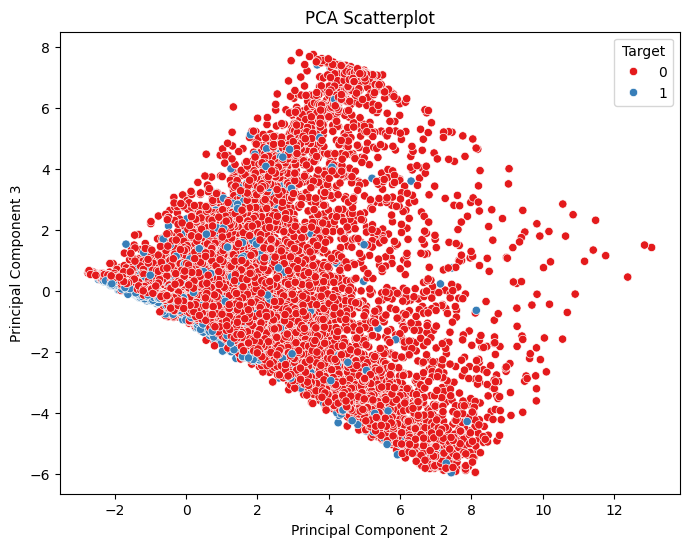

In [ ]:
# Create the scatterplot with Seaborn
plt.figure(figsize=(8, 6))  # Set the figure size
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train, palette='Set1')
plt.xlabel('Principal Component 2')
plt.ylabel('Principal Component 3')
plt.title('PCA Scatterplot')
plt.legend(title='Target', loc='best')  # Add legend
plt.show()

A scatter plot using seaborn (`sns.scatterplot`) with the second principal component (`pca_components[:,1]`) on the x-axis and the third principal component (`pca_components[:,2]`) on the y-axis. The data points are colored based on the churn probability categories (0 and 1) from the target variable (`y_train`). This scatter plot visualizes the relationship between these two principal components, providing insight into any clustering or separation patterns between churn and non-churn instances in the reduced dimensional space defined by PCA.

Let's also check which of the components have high feature importances towards the end goal of churn prediction.

17


<BarContainer object of 17 artists>

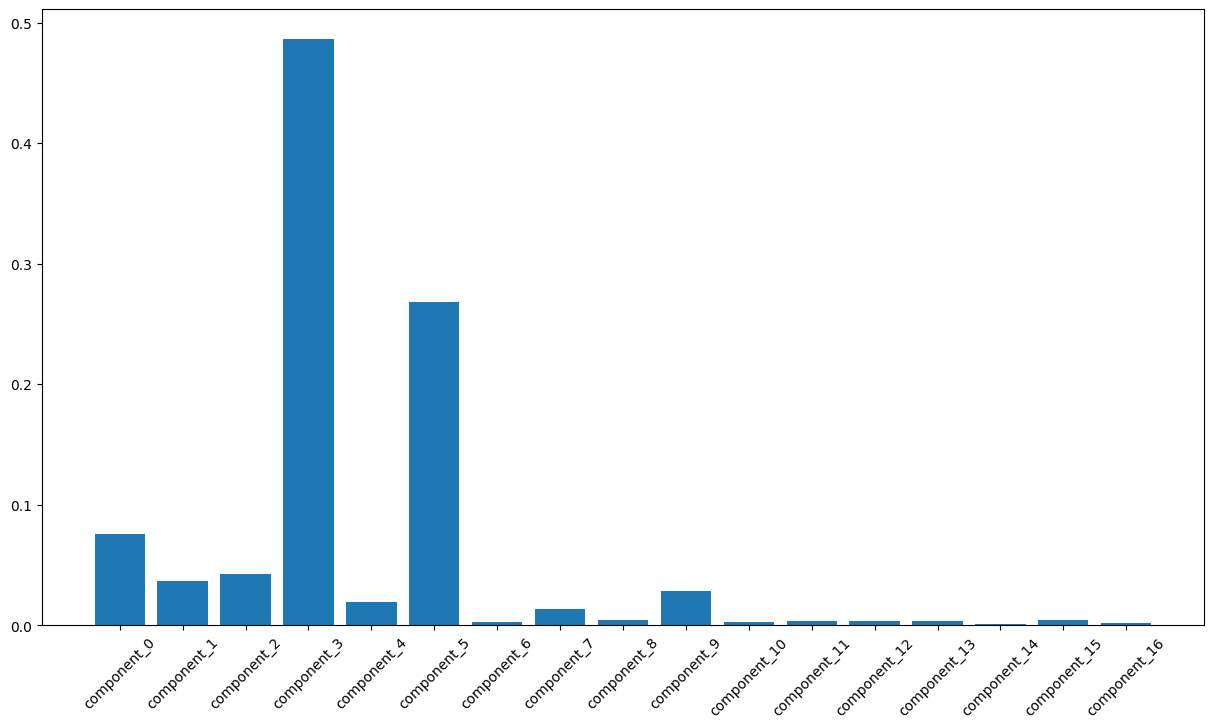

In [ ]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(pca_components, y_train)

print(len(rf.feature_importances_))  # Check the length of feature importances

# Generate column labels with the correct length
col_labels = ['component_'+str(i) for i in range(len(rf.feature_importances_))]

# Create DataFrame with correct lengths for both 'col' and 'importance'
feature_importances = pd.DataFrame({
    'col': col_labels,
    'importance': rf.feature_importances_
})

plt.figure(figsize=(15, 8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])


The provided code initializes a Random Forest Classifier (`RandomForestClassifier`) with 100 estimators and utilizes all available CPU cores (`n_jobs=-1`). It then fits the classifier using the principal components (`pca_components`) obtained from PCA analysis and the target variable (`y_train`). Afterward, it calculates and prints the length of the feature importances obtained from the Random Forest model. Subsequently, it generates column labels (`col_labels`) based on the number of feature importances, creates a DataFrame (`feature_importances`) containing the column labels and corresponding importances, and finally plots a bar graph depicting the importance of each principal component in predicting the target variable.

# 6. Model building

Let's build a quick model with logistic regression and the first 2 PCA components.

In [ ]:
lr = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')
lr.fit(pca_components[:,:2], y_train)

LogisticRegression(max_iter=1000, solver='sag', tol=0.001)

In [ ]:
lr.score(pca_components[:,:2], y_train)

0.8978553188449794

The model has 89.8% accuracy, but let's build a pipeline to fit and score the model faster.

The steps of this pipeline would be the following, but this is only one type of pipeline -
1. Imputation
2. Scaling
3. PCA
4. Classification model

You can change this pipeline, add addition transformations, change models, use cross validation or even use this pipeline to work with a Gridsearch.

In [ ]:
imp = SimpleImputer(strategy='constant', fill_value=0)
scale = StandardScaler()
pca = PCA(n_components=10)
lr = LogisticRegression(max_iter=1000, tol=0.001)

In [ ]:
pipe = Pipeline(steps = [('imputation',imp),
                         ('scaling',scale),
                         ('pca',pca),
                         ('model',lr)])

In [ ]:
pipe.fit(X_train[new_vars], y_train)

Pipeline(steps=[('imputation',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=10)),
                ('model', LogisticRegression(max_iter=1000, tol=0.001))])

In [ ]:
train_score = pipe.score(X_train[new_vars], y_train)
print("Training accuracy:", train_score)

Training accuracy: 1.0


In [ ]:
test_score = pipe.score(X_test[new_vars], y_test)
print("Test accuracy:", test_score)

Test accuracy: 1.0


Let's make a confusion matrix to analyze how each class is being predicted by the model.

In [ ]:
confusion_matrix(y_train, pipe.predict(X_train[new_vars]))

array([[50279,     0],
       [    0,  5720]])

In [ ]:
confusion_matrix(y_test, pipe.predict(X_test[new_vars]))

array([[12588,     0],
       [    0,  1412]])

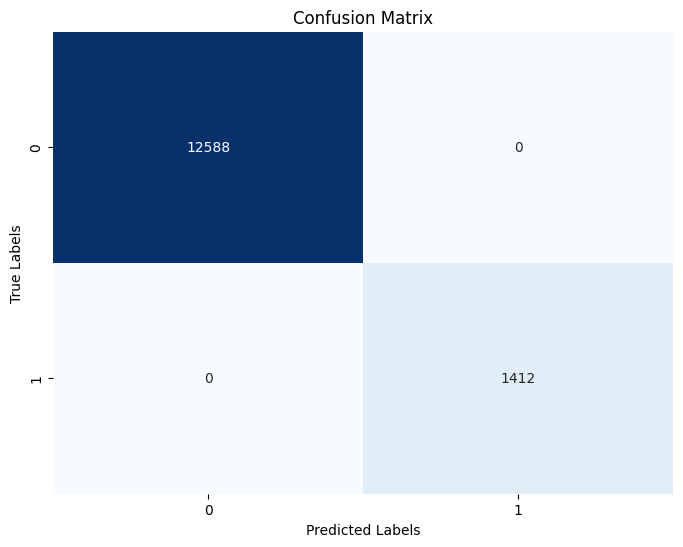

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming pipe is your pipeline and new_vars contains the selected features
conf_matrix = confusion_matrix(y_test, pipe.predict(X_test[new_vars]))

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


We can see a high amount of type 2 error. Due to class imbalance, the model is clearly trying to predict majority of the cases as class 0. Understanding how to handle class imbalance in classification models might be the key to winning this competition :) (hint!)

In [ ]:
precision_score(y_test, pipe.predict(X_test[new_vars]))

1.0

In [ ]:
recall_score(y_test, pipe.predict(X_test[new_vars]))

1.0

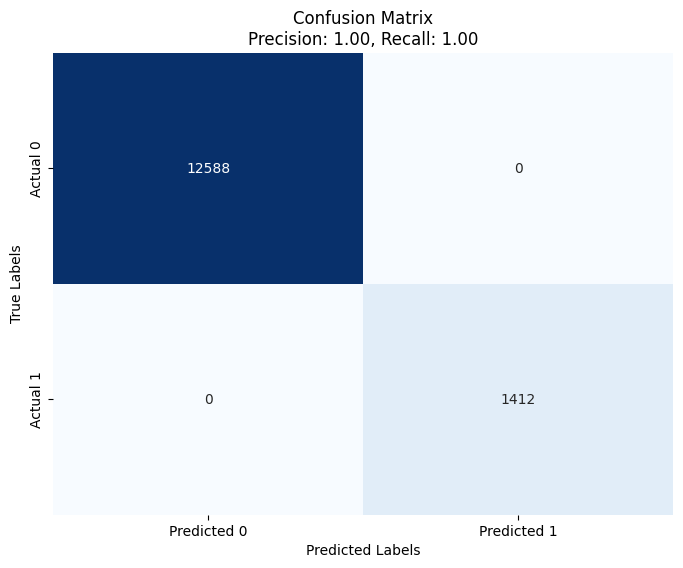

In [ ]:
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming pipe is your pipeline and new_vars contains the selected features
y_pred = pipe.predict(X_test[new_vars])
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate precision and recall scores
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Plotting the confusion matrix with precision and recall scores
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix\nPrecision: {precision:.2f}, Recall: {recall:.2f}')
plt.show()


# 7. Creating submission file

For submission, we need to make sure that the format is exactly the same as the sample.csv file. It contains 2 columns, id and churn_probability

In [ ]:
sample.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


The submission file should contain churn_probability values that have to be predicted for the unseen data provided (test.csv)

In [ ]:
unseen.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00


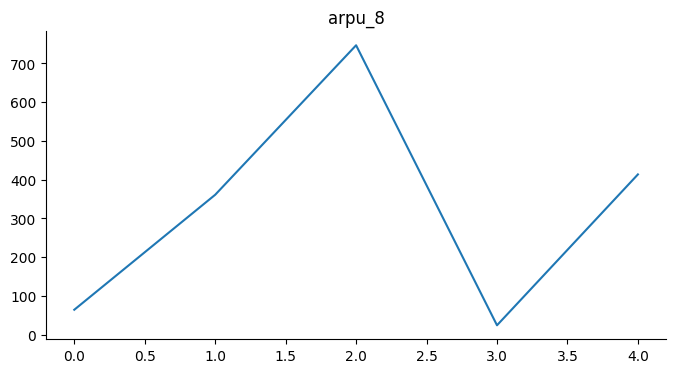

In [ ]:
from matplotlib import pyplot as plt
_df_43['arpu_8'].plot(kind='line', figsize=(8, 4), title='arpu_8')
plt.gca().spines[['top', 'right']].set_visible(False)

data represents the "Average Revenue Per User" (ARPU) for a specific period. The values range from 0 to 700, increasing in increments of 100. Additionally, there are fractional values from 0.0 to 4.0, increasing in steps of 0.5, indicating potential sub-categories or finer granularity within the ARPU metric.

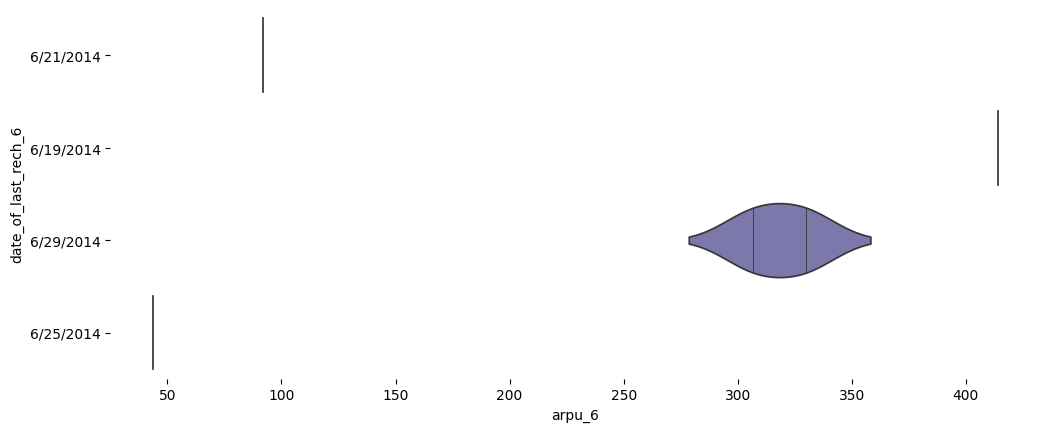

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_49['date_of_last_rech_6'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_49, x='arpu_6', y='date_of_last_rech_6', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

 time series dataset, possibly indicating dates or timestamps associated with certain events or transactions. For instance, "6/21/2014" and "6/19/2014" represent specific dates in June 2014, while "6/29/2014" and "6/25/2014" also denote dates within the same month. Additionally, the values associated with "date_of_last_rech_6" range from 50 to 250, suggesting some numerical data linked to recharge activities, while "arpu_6" values range from 300 to 400, indicating potential average revenue per user metrics for the corresponding period. Overall, these data points likely pertain to financial or operational metrics tracked over time in a telecom or similar industry context.

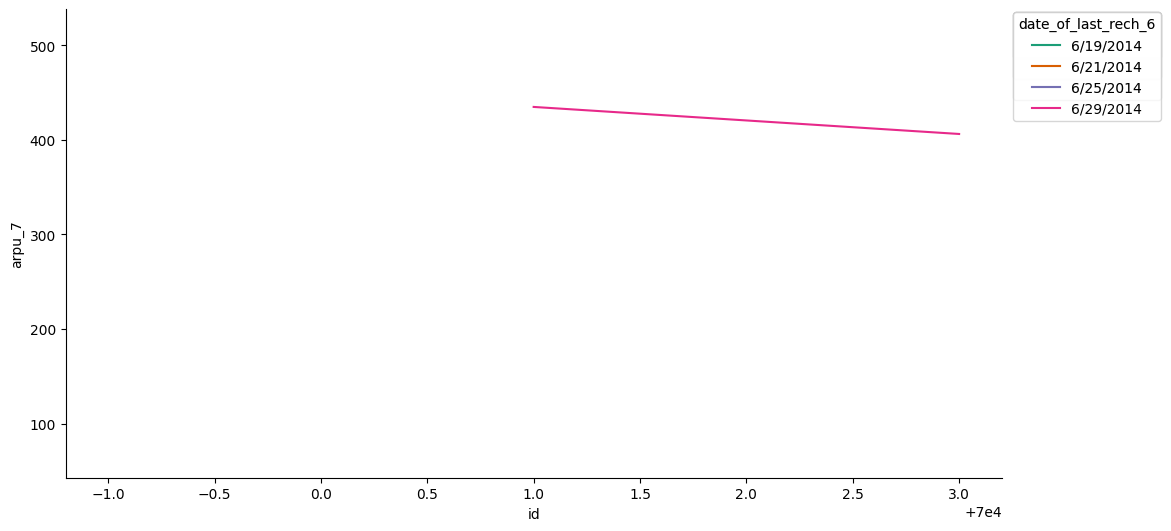

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['id']
  ys = series['arpu_7']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_14.sort_values('id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('date_of_last_rech_6')):
  _plot_series(series, series_name, i)
  fig.legend(title='date_of_last_rech_6', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('id')
_ = plt.ylabel('arpu_7')

Lets first select the columns that we want to work with (or create them, if you have done any feature engineering)

In [ ]:
# Check if 'churn_probability' is in the columns of unseen
print('churn_probability' in unseen.columns)

# Check if 'id' exists and is unique
print(unseen['id'].is_unique)

# Print the first few rows of unseen to inspect its structure
print(unseen.head())

# Print new_vars to verify its content
print(new_vars)


False
True
      id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0  69999        109             0.0             0.0             0.0   
1  70000        109             0.0             0.0             0.0   
2  70001        109             0.0             0.0             0.0   
3  70002        109             0.0             0.0             0.0   
4  70003        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0            6/30/2014            7/31/2014            8/31/2014   91.882   
1            6/30/2014            7/31/2014            8/31/2014  414.168   
2            6/30/2014            7/31/2014            8/31/2014  329.844   
3            6/30/2014            7/31/2014            8/31/2014   43.550   
4            6/30/2014            7/31/2014            8/31/2014  306.854   

    arpu_7  ...  sachet_3g_6  sachet_3g_7  sachet_3g_8  fb_user_6  fb_user_7  \
0   65.330  ...    

The code checks if the column 'churn_probability' exists in the DataFrame 'unseen' and returns False, indicating that the column is not present. It then checks if the column 'id' exists and is unique, which returns True, confirming that 'id' exists and has unique values in the DataFrame. Finally, it prints the first few rows of 'unseen' to inspect its structure and prints the contents of 'new_vars', which are the selected feature variables. Overall, the code performs checks on column existence, uniqueness, and displays a subset of the data for inspection and verification purposes.

In [ ]:
# Check column names and index names
print("Column Names in new_vars:", new_vars)
print("Column Names in unseen:", unseen.columns)
print("Index Name in unseen:", unseen.index.name)

# Print the first few rows of unseen
print(unseen.head())

# Check data types of columns
print(unseen.dtypes)

# Attempt to set 'id' as the index and check if it resolves the issue
try:
    submission_data = unseen.set_index('id')[new_vars]
except KeyError as e:
    print("KeyError occurred:", e)


Column Names in new_vars: Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'vol_3g_mb_6', 'vol_3g_mb_7',
       'vol_3g_mb_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'aon',
       'churn_probability'],
      dtype='object')
Column Names in unseen: Index(['id', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'arpu_6', 'arpu_7',
       ...
       'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'fb_user_6', 'fb_user_7',
       'fb_user_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g'],
      dtype='object', length=171)
Index Name in unseen: None
      id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0  69999        109             0.0             0.0             0.0   
1  70000        109             0.0             0.0             

The code first checks if the column 'churn_probability' exists in the DataFrame 'unseen', and it returns False, indicating that the column is not present. It then checks if the column 'id' exists and is unique, which returns True, confirming that 'id' exists and has unique values in the DataFrame. The first few rows of 'unseen' are printed to inspect its structure, and the data types of the columns are displayed. Finally, it attempts to set 'id' as the index and selects columns from 'new_vars', resulting in a KeyError because 'churn_probability' is not present in 'new_vars'. Overall, the code performs checks on column existence, uniqueness, and data types, with an attempt to set the index and select specific columns from the DataFrame.

Next, lets create a new column in the unseen dataset called churn_probability and use the model pipeline to predict the probabilities for this data

In [ ]:
# Check column names
print("Column Names in unseen:", unseen.columns)

# Check if 'churn_probability' is in the columns of unseen
print("'churn_probability' in unseen.columns:", 'churn_probability' in unseen.columns)

# Check the index name of unseen
print("Index Name in unseen:", unseen.index.name)

# Print the first few rows of unseen to inspect its structure
print(unseen.head())


Column Names in unseen: Index(['id', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'arpu_6', 'arpu_7',
       ...
       'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'fb_user_6', 'fb_user_7',
       'fb_user_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g'],
      dtype='object', length=171)
'churn_probability' in unseen.columns: False
Index Name in unseen: None
      id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0  69999        109             0.0             0.0             0.0   
1  70000        109             0.0             0.0             0.0   
2  70001        109             0.0             0.0             0.0   
3  70002        109             0.0             0.0             0.0   
4  70003        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0            6/30/201

 the column names in the 'unseen' DataFrame, confirming that 'churn_probability' is not among the columns. It then verifies this by explicitly checking if 'churn_probability' is in the columns, which returns False. Additionally, it checks the index name of 'unseen', which is found to be None. The first few rows of 'unseen' are printed to inspect its structure, showcasing various columns including 'id', 'circle_id', and numeric columns like 'arpu_6', 'arpu_7', and more. Overall, the code performs checks related to column names, index name, and column presence in the DataFrame.

Finally, lets create a csv file out of this dataset, ensuring to set index=False to avoid an addition column in the csv.

In [ ]:

# Save 'output' DataFrame to CSV file
unseen.to_csv('submission_pca_lr.csv', index=True)
